In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import io
import os
import sys
from typing import (
    Dict, 
    List
)
import warnings


from datetime import datetime

import re
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
sys.path.append(os.path.join(os.getcwd(), '..'))

In [4]:
from utils.features_analysis_tools import mark_features_with_not_null_level_lower_than

In [5]:
# set constants
MIN_PRCNT_NOT_NULL: int = 100
MIN_N_UNIQUE_VALS: int = 2
MAX_N_UNIQUE_CONT_VALS: int = 40
MIN_IV: float = 0.01
CORR_PEARSON_CUT_OFF: float = 0.75


TARGET_NAME: str = 'GB6_Flag_2Limit'
PALETTE_TARGET: Dict[str, str] = {
    'G': 'green',
    'B': 'red',
    'I': 'black'
}
TARGET_BIN: str = f'_{TARGET_NAME}_bin'

DATA_PATH: str = os.path.join(os.getcwd(), '..')
DATA_PATH = os.path.join(DATA_PATH, 'data')

In [6]:
df = pd.read_csv(os.path.join(DATA_PATH, 'Cahplus Final Dataset + ML__17062024.csv'), low_memory=False)

In [7]:
print('Cahplus Final Dataset + ML__17062024; Number of rows: %.0f; columns: %.0f' % df.shape)

Cahplus Final Dataset + ML__17062024; Number of rows: 110462; columns: 1481


In [8]:
[col for col in df.columns if 'id' in col.lower()]

['UNIQUE_ID', 'ND_OPT_OUT_VALID']

In [9]:
# read data
df_final: pd.DataFrame = pd.read_csv(os.path.join(DATA_PATH, 'Final_Dataset.csv'), low_memory=False)
df_aiq2: pd.DataFrame = pd.read_csv(os.path.join(DATA_PATH, 'AIQ2 Block - Cashplus.csv'))

In [10]:
print('Final; Number of rows: %.0f; columns: %.0f' % df_final.shape)
print('AIQ 2; Number of rows: %.0f; columns: %.0f' % df_aiq2.shape)

Final; Number of rows: 110462; columns: 1413
AIQ 2; Number of rows: 110462; columns: 358


In [11]:
# compare columns of the new and previous datase's versions
print('# New columns: ', len(set(df.columns).difference(df_final.columns)))
print('New columns: ', set(df.columns).difference(df_final.columns))

# New columns:  72
New columns:  {'VO_013', 'TS_004', 'PA_006', 'TS_003', 'PR_007', 'PR_006', 'VO_001', 'PR_010', 'PR_002', 'SE_003', 'TV_002', 'PR_012', 'BA_010', 'PA_003', 'SE_002', 'PR_005', 'BA_008', 'BA_004', 'VO_011', 'PR_013', 'PR_009', 'PR_004', 'VO_006', 'AR_001', 'VO_002', 'VO_007', 'PC_001', 'TS_001', 'BA_001', 'TV_006', 'PC_005', 'PA_008', 'PR_003', 'VO_004', 'PA_010', 'VO_014', 'VO_012', 'PC_003', 'PR_011', 'PR_001', 'AR_004', 'PC_004', 'PA_004', 'SE_001', 'AR_003', 'PA_009', 'BA_002', 'PA_011', 'BA_006', 'AR_002', 'PA_001', 'VO_009', 'BA_005', 'VO_005', 'PA_005', 'PA_007', 'TV_005', 'PC_002', 'BA_003', 'VO_008', 'VO_003', 'TV_003', 'BA_007', 'PR_008', 'PC_006', 'TS_002', 'TV_004', 'TV_001', 'VO_010', 'VO_015', 'PA_002', 'BA_009'}


In [12]:
# compare columns of the new and previous datase's versions
print('# Missed old columns: ', len(set(df_final.columns).difference(df.columns)))
print('Missed old columns:', set(df_final.columns).difference(df.columns))

# Missed old columns:  4
Missed old columns: {'OPTIN_11BWN_ML', 'OPTOUT_11BWN_ML', 'OPTIN_11RWN_ML', 'OPTOUT_11RWN_ML'}


In [13]:
# compare columns of the new and previous datase's versions
assert len(set(df.columns).difference(df_aiq2.columns)) != df.shape[0]

In [14]:
# compare columns of the new and previous datase's versions
assert len(set(df.columns).difference(df_aiq2.columns)) != df_aiq2.shape[0]

In [15]:
cols_inter: List[str] = list(set(df_aiq2.columns.tolist()).intersection(set(df.columns.tolist())))
print('AIQ 2 has common features with the final: ', len(cols_inter), '/', df_aiq2.shape[1])
print(cols_inter)

AIQ 2 has common features with the final:  23 / 358
['TRD_RAG_12', 'TRD_RAG_05', 'TRD_RAG_15', 'TRD_RAG_18', 'TRD_RAG_20', 'TRD_RAG_23', 'TRD_RAG_08', 'TRD_RAG_19', 'TRD_RAG_21', 'TRD_RAG_07', 'TRD_RAG_14', 'TRD_RAG_03', 'TRD_RAG_11', 'TRD_RAG_10', 'TRD_RAG_09', 'TRD_RAG_17', 'TRD_RAG_16', 'TRD_RAG_13', 'TRD_RAG_02', 'TRD_RAG_04', 'TRD_RAG_22', 'TRD_RAG_06', 'TRD_RAG_01']


In [16]:
# check if the duplicated columns have the same values 
df = df.set_index('UNIQUE_ID')
df_aiq2 = df_aiq2.set_index('UNIQUEID')

print('If the duplicated columns have the same values: ', df[cols_inter].equals(df_aiq2.loc[df.index, cols_inter]))

If the duplicated columns have the same values:  False


In [17]:
# check a random column
pd.concat(
    (
        df[['TRD_RAG_10']].rename(columns={'TRD_RAG_10': 'TRD_RAG_10_final'}),
        pd.DataFrame(df['TRD_RAG_10'] == df_aiq2.loc[df.index, 'TRD_RAG_10']).rename(columns={'TRD_RAG_10': 'IfEqual'}),
        df_aiq2.loc[df.index, ['TRD_RAG_10']].rename(columns={'TRD_RAG_10': 'TRD_RAG_10_AIQ2'})
    ), axis=1,
).reset_index().set_index(['IfEqual', 'UNIQUE_ID']).loc[False, :, :].head()

,TRD_RAG_10_final,TRD_RAG_10_AIQ2
UNIQUE_ID,,
11098418,G,R
40700950,A,G
12347944,R,G
25269079,G,R
5548940,R,G


In [18]:
# rename columns in the AIQ2 dataset
aiq2_inter_cols: List[str] = [col + '_AIQ2' for col in cols_inter]
df_aiq2 = df_aiq2.rename(columns=dict(zip(cols_inter, aiq2_inter_cols)))

In [19]:
# check after renaming
cols_inter_check: List[str] = list(set(df_aiq2.columns.tolist()).intersection(set(df.columns.tolist())))
print('AIQ 2 has common features with the final: ', len(cols_inter_check), '/', df_aiq2.shape[1])
print(cols_inter_check)

AIQ 2 has common features with the final:  0 / 357
[]


In [20]:
# merge datasets
df = df.reset_index()
df_aiq2 = df_aiq2.reset_index()
df: pd.DataFrame = pd.merge(df, df_aiq2, left_on='UNIQUE_ID', right_on='UNIQUEID', how='outer', suffixes=('', '_AIQ2'))

In [21]:
# merge old datasets
df_final: pd.DataFrame = pd.merge(df_final, df_aiq2, left_on='UNIQUE_ID', right_on='UNIQUEID', how='outer', suffixes=('', '_AIQ2'))
del df_aiq2

In [22]:
# check stats after merge
print('Number of rows: %.0f; columns: %.0f' % df.shape)
print('Number of unique IDs: ', df.UNIQUE_ID.nunique())

Number of rows: 110462; columns: 1839
Number of unique IDs:  110462


In [23]:
# check stats after merge
print('Number of rows: %.0f; columns: %.0f' % df_final.shape)
print('Number of unique IDs: ', df_final.UNIQUE_ID.nunique())

Number of rows: 110462; columns: 1771
Number of unique IDs:  110462


# Target

In [24]:
print('Column:', TARGET_NAME)
print('If any Nulls: ', df[TARGET_NAME].isnull().any())

Column: GB6_Flag_2Limit
If any Nulls:  False


In [26]:
print('Distribution: ')
pd.merge(
    pd.DataFrame(df[TARGET_NAME].value_counts().rename('Target (counts)')),
    pd.DataFrame((df[TARGET_NAME].value_counts(normalize=True) * 100).round(3).rename('Target (%)')), 
    left_index=True, right_index=True
)

Distribution: 


,Target (counts),Target (%)
GB6_Flag_2Limit,,
G,99444,90.026
I,6569,5.947
B,4449,4.028


In [27]:
# binarized target
df[f'{TARGET_BIN}'] = (df[TARGET_NAME] == 'B').astype(int)

In [28]:
print('Binarized target: ', TARGET_BIN)
print('Distribution: ')
pd.merge(
    pd.DataFrame(df[TARGET_BIN].value_counts().rename('Target (counts)')),
    pd.DataFrame((df[TARGET_BIN].value_counts(normalize=True) * 100).round(3).rename('Target (%)')), 
    left_index=True, right_index=True
)

Binarized target:  _GB6_Flag_2Limit_bin
Distribution: 


,Target (counts),Target (%)
_GB6_Flag_2Limit_bin,,
0,106013,95.972
1,4449,4.028


# RETRO_DATE

In [29]:
print('Date format:')
df.RETRO_DATE.head()

Date format:


0    13APR2022
1    26OCT2023
2    12MAR2023
3    04OCT2021
4    26AUG2023
Name: RETRO_DATE, dtype: object

In [30]:
df['_RDATE'] = df.RETRO_DATE.apply(lambda x: datetime.strptime(x, '%d%b%Y').date()).values

In [31]:
print('Available date range:')
df['_RDATE'].agg(['min', 'max'])

Available date range:


min    2021-06-30
max    2023-11-30
Name: _RDATE, dtype: object

In [32]:
print('Examples of unique dates: ')
df['_RDATE'].sort_values().unique()[:5]

Examples of unique dates: 


array([datetime.date(2021, 6, 30), datetime.date(2021, 7, 1),
       datetime.date(2021, 7, 2), datetime.date(2021, 7, 3),
       datetime.date(2021, 7, 4)], dtype=object)

In [33]:
# create end of month for aggregations:
df['_RDATE_EOM'] = pd.to_datetime(df['_RDATE'] + pd.tseries.offsets.MonthEnd(0)).dt.date

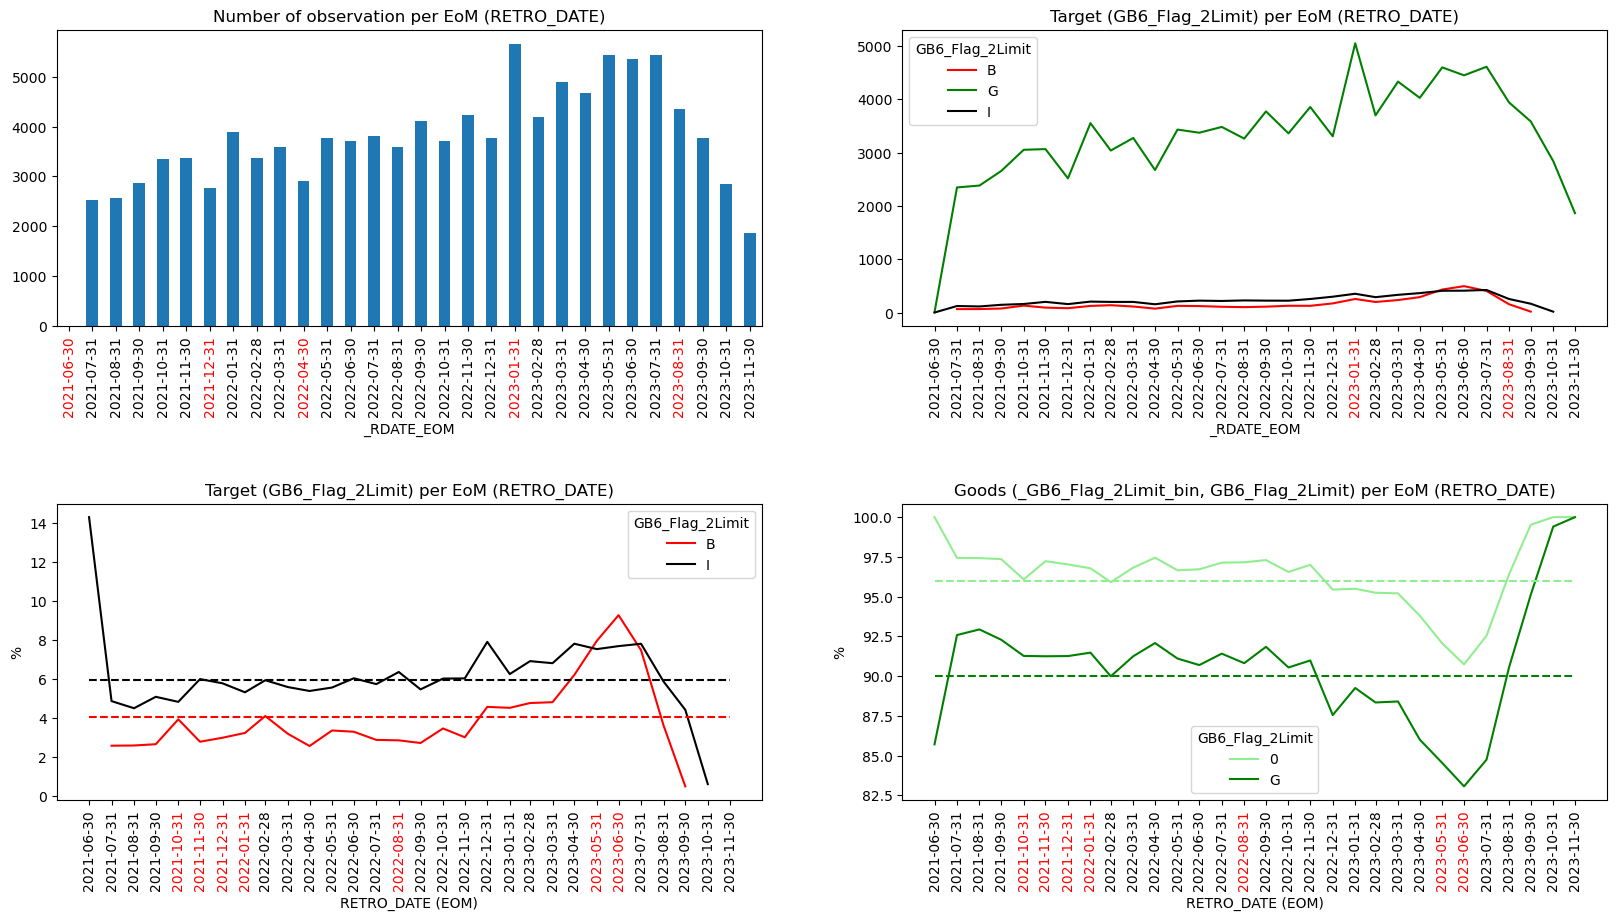

In [35]:
#  distributions 
# - number of observations per month
# - target as is, binary 
f, ax = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
plt.subplots_adjust(hspace=0.6)

_ = df['_RDATE_EOM'].value_counts(sort=False).sort_index().plot(kind='bar',  title='Number of observation per EoM (RETRO_DATE)', ax=ax[0, 0])

for date_val in ['2021-06-30', '2021-12-31', '2022-04-30', '2023-01-31','2023-08-31']: 
    _ = ax[0, 0].get_xticklabels()[np.where(np.sort(df['_RDATE_EOM'].unique()) == pd.to_datetime(date_val).date())[0][0]].set_color("red")

_ = pd.DataFrame(df.groupby(['_RDATE_EOM'])[TARGET_NAME].value_counts(sort=False).sort_index().rename('n')).reset_index()\
    .pivot(index='_RDATE_EOM', columns=TARGET_NAME, values='n')\
    .plot\
    .line(
        color=PALETTE_TARGET,
        title=f'Target ({TARGET_NAME}) per EoM (RETRO_DATE)', 
        rot=90, 
        xticks=np.sort(df._RDATE_EOM.unique()),
        ax=ax[0, 1]
    )
_ = ax[0, 1].get_xticklabels()[np.where(np.sort(df['_RDATE_EOM'].unique()) == pd.to_datetime('2023-01-31').date())[0][0]].set_color("red")
_ = ax[0, 1].get_xticklabels()[np.where(np.sort(df['_RDATE_EOM'].unique()) == pd.to_datetime('2023-08-31').date())[0][0]].set_color("red")


_ = pd.DataFrame((df.groupby(['_RDATE_EOM'])[TARGET_NAME].value_counts(normalize=True, sort=False) * 100).sort_index().rename('n')).reset_index()\
    .pivot(index='_RDATE_EOM', columns=TARGET_NAME, values='n')\
    .drop(columns=['G'])\
    .plot\
    .line(
        color=PALETTE_TARGET,
        title=f'Target ({TARGET_NAME}) per EoM (RETRO_DATE)', 
        rot=90, 
        xticks=np.sort(df._RDATE_EOM.unique()),
        ylabel='%', 
        xlabel = 'RETRO_DATE (EOM)', 
        ax=ax[1, 0]
    )
for date_value in ['2021-10-31', '2021-11-30', '2021-12-31', '2022-01-31', '2022-08-31', '2023-05-31', '2023-06-30']:
    _ = ax[1, 0].get_xticklabels()[np.where(np.sort(df['_RDATE_EOM'].unique()) == pd.to_datetime(date_value).date())[0][0]].set_color("red")

_ = ax[1, 0].hlines(y=df[TARGET_NAME].value_counts(normalize=True)['B'] * 100, xmin=pd.to_datetime('2021-06-30').date(), xmax=pd.to_datetime('2023-11-30').date(), color=PALETTE_TARGET['B'], label='B-Overall', linestyle='dashed')
_ = ax[1, 0].hlines(y=df[TARGET_NAME].value_counts(normalize=True)['I'] * 100, xmin=pd.to_datetime('2021-06-30').date(), xmax=pd.to_datetime('2023-11-30').date(), color=PALETTE_TARGET['I'], label='I-Overall', linestyle='dashed')
# _ = plt.legend()

_ = pd.DataFrame((df.groupby(['_RDATE_EOM'])[TARGET_BIN].value_counts(normalize=True, sort=False) * 100).sort_index().rename('n')).reset_index()\
    .pivot(index='_RDATE_EOM', columns=TARGET_BIN, values='n')\
    .drop(columns=[1])\
    .plot\
    .line(
        color={0: 'lightgreen', 1: 'red'},
        title=f'Target ({TARGET_BIN}) per EoM (RETRO_DATE)', 
        rot=90, 
        xticks=np.sort(df._RDATE_EOM.unique()),
        ylabel='%', 
        xlabel = 'RETRO_DATE (EOM)', 
        ax=ax[1, 1]
    )
_ = pd.DataFrame((df.groupby(['_RDATE_EOM'])[TARGET_NAME].value_counts(normalize=True, sort=False) * 100).sort_index().rename('n')).reset_index()\
    .pivot(index='_RDATE_EOM', columns=TARGET_NAME, values='n')\
    .drop(columns=['B', 'I'])\
    .plot\
    .line(
        color={'G': 'green'},
        title=f'Goods ({TARGET_BIN}, {TARGET_NAME}) per EoM (RETRO_DATE)', 
        rot=90, 
        xticks=np.sort(df._RDATE_EOM.unique()),
        ylabel='%', 
        xlabel = 'RETRO_DATE (EOM)', 
        ax=ax[1, 1]
    )
for date_value in ['2021-10-31', '2021-11-30', '2021-12-31', '2022-01-31', '2022-08-31', '2023-05-31', '2023-06-30']:
    _ = ax[1, 1].get_xticklabels()[np.where(np.sort(df['_RDATE_EOM'].unique()) == pd.to_datetime(date_value).date())[0][0]].set_color("red")

_ = ax[1, 1].hlines(y=df[TARGET_NAME].value_counts(normalize=True)['G'] * 100, xmin=pd.to_datetime('2021-06-30').date(), xmax=pd.to_datetime('2023-11-30').date(), color='green', label='G-Overall', linestyle='dashed')
_ = ax[1, 1].hlines(y=df[TARGET_BIN].value_counts(normalize=True)[0] * 100, xmin=pd.to_datetime('2021-06-30').date(), xmax=pd.to_datetime('2023-11-30').date(), color='lightgreen', label='0-Overall', linestyle='dashed')


In [36]:
print('Target population of the ends:')
pd.concat(
    (
        pd.DataFrame(df.groupby(['_RDATE_EOM'])[TARGET_NAME].value_counts(sort=False).sort_index().rename('n')).head(5),
        pd.DataFrame(df.groupby(['_RDATE_EOM'])[TARGET_NAME].value_counts(sort=False).sort_index().rename('n')).tail(6)
    )
)

Target population of the ends:


n
_RDATE_EOM GB6_Flag_2Limit      
2021-06-30 G                   6
           I                   1
2021-07-31 B                  65
           G                2348
           I                 123
2023-09-30 B                  18
           G                3586
           I                 166
2023-10-31 G                2842
           I                  17
2023-11-30 G                1865

In [37]:
columns_final: List[str] = [
'UNIQUE_ID',
'RETRO_DATE',
'E1_A_01',
'E1_A_02',
'E1_A_03',
'E1_A_04',
'E1_A_05',
'E1_A_06',
'E1_A_07',
'E1_A_08',
'E1_A_09',
'E1_A_10',
'E1_A_11',
'E1_B_01',
'E1_B_02',
'E1_B_03',
'E1_B_04',
'E1_B_05',
'E1_B_06',
'E1_B_07',
'E1_B_08',
'E1_B_09',
'E1_B_10',
'E1_B_11',
'E1_B_12',
'E1_B_13',
'E1_C_01',
'E1_C_02',
'E1_C_03',
'E1_C_04',
'E1_C_05',
'E1_C_06',
'E1_D_01',
'E1_D_02',
'E1_D_03',
'E1_D_04',
'E1_E_01',
'E1_E_02',
'E2_G_01',
'E2_G_02',
'E2_G_03',
'E2_G_04',
'E2_G_05',
'E2_G_06',
'E2_G_07',
'E2_G_08',
'E2_G_09',
'E2_G_10',
'E2_G_11',
'E2_H_01',
'E2_H_02',
'E2_H_03',
'E2_H_04',
'E2_H_05',
'E2_H_06',
'E2_H_07',
'E2_H_08',
'E2_H_09',
'E2_H_10',
'E2_H_11',
'E2_H_12',
'E2_H_13',
'E2_I_01',
'E2_I_02',
'E2_I_03',
'E2_I_04',
'E2_I_05',
'E2_I_06',
'E2_J_01',
'E2_J_02',
'E2_J_03',
'E2_J_04',
'E2_K_01',
'E2_K_02',
'E4_Q_01',
'E4_Q_02',
'E4_Q_03',
'E4_Q_04',
'E4_Q_05',
'E4_Q_06',
'E4_Q_07',
'E4_Q_08',
'E4_Q_09',
'E4_Q_10',
'E4_Q_11',
'E4_Q_12',
'E4_Q_13',
'E4_Q_14',
'E4_Q_15',
'E4_Q_16',
'E4_Q_17',
'E4_Q_18',
'E4_R_01',
'E4_R_03',
'EA1_A_01',
'ND_ECC_01',
'ND_ECC_02',
'ND_ECC_03',
'EA1_B_01',
'EA1_B_02',
'ND_ECC_04',
'ND_HAC_01',
'ND_HAC_02',
'ND_HAC_03',
'ND_HAC_04',
'ND_HAC_05',
'ND_INC_01',
'EA1_C_01',
'EA1_C_02',
'ND_PSD_01',
'ND_PSD_02',
'ND_PSD_03',
'ND_PSD_04',
'ND_PSD_05',
'ND_PSD_06',
'EA1_D_01',
'EA1_D_02',
'EA1_D_03',
'ND_ERL_01',
'ND_FCS_01',
'EA1_E_01',
'EA1_E_02',
'EA1_E_03',
'EA1_E_04',
'EA1_F_01',
'EA1_F_03',
'EA1_F_04',
'EA1_G_01',
'EA1_G_02',
'EA4_Q_07',
'EA4_Q_08',
'SP_BR_PRESENT',
'SPA_BR_PRESENT',
'SUS_IND',
'EA2_G_01',
'ND_PSD_07',
'ND_PSD_08',
'ND_PSD_09',
'ND_PSD_10',
'EA4_Q_09',
'EA4_Q_10',
'EA4_Q_11',
'EA2_H_01',
'EA2_H_02',
'ND_ECC_07',
'ND_ECC_08',
'ND_ERL_02',
'EA2_Q_01',
'EA2_Q_02',
'ND_ECC_09',
'ND_ECC_10',
'EA2_I_01',
'EA2_I_02',
'ND_FCS_02',
'EA2_J_01',
'EA2_J_02',
'EA2_J_03',
'ND_HAC_09',
'EA2_K_01',
'EA2_K_02',
'EA2_K_03',
'EA2_K_04',
'ND_HAC_10',
'EA2_L_01',
'EA2_L_03',
'EA2_L_04',
'EA2_M_01',
'EA2_M_02',
'ND_ECC_05',
'ND_HAC_06',
'ND_HAC_07',
'ND_HAC_08',
'ND_INC_02',
'ND_OPT_OUT',
'ND_OPT_OUT_VALID',
'ND_LNK_01',
'ND_ECC_06',
'ND_INC_03',
'ND_PSD_11',
'ND_ERL_MACA',
'ND_ERL_MAPA',
'ND_ERL_JACA',
'ND_ERL_JAPA',
'EA4_P_01',
'EA4_Q_01',
'EA4_Q_02',
'EA4_Q_03',
'EA4_Q_04',
'EA4_Q_05',
'EA4_Q_06',
'EA4_R_01_PM',
'EA4_R_01_CJ',
'EA4_R_01_PJ',
'EA4_S_01',
'EA4_S_02',
'EA4_S_03',
'EA4_S_04',
'EA4_S_05',
'EA4_S_06',
'EA4_S_07',
'EA4_S_08',
'EA5_S_01',
'EA5_U_01',
'EA5_U_02',
'E5_S_01',
'E5_S_02',
'SP_A_01',
'SP_A_02',
'SP_A_03',
'SP_A_04',
'SP_A_05',
'SP_A_06',
'SP_A_07',
'SP_A_08',
'SP_A_09',
'SP_A_10',
'SP_B1_11',
'SP_B1_12',
'SP_B1_13',
'SP_B1_14',
'SP_B1_15',
'SP_B1_16',
'SP_B1_17',
'SP_B2_18',
'SP_B2_19',
'SP_B2_20',
'SP_B2_21',
'SP_B3_22',
'SP_B3_23',
'SP_C_24',
'SP_D_25',
'SP_E1_26',
'SP_E1_27',
'SP_E1_28',
'SP_F1_29',
'SP_F1_30',
'SP_F1_31',
'SP_F2_32',
'SP_F2_33',
'SP_F3_34',
'SP_F3_35',
'SP_F3_36',
'SP_G_37',
'SP_G_38',
'SPA_A_01',
'SPA_A_02',
'SPA_A_03',
'SPA_A_04',
'SPA_A_05',
'SPA_A_06',
'SPA_A_07',
'SPA_A_08',
'SPA_A_09',
'SPA_A_10',
'SPA_B1_11',
'SPA_B1_12',
'SPA_B1_13',
'SPA_B1_14',
'SPA_B1_15',
'SPA_B1_16',
'SPA_B1_17',
'SPA_B2_18',
'SPA_B2_19',
'SPA_B2_20',
'SPA_B2_21',
'SPA_B3_22',
'SPA_B3_23',
'SPA_C_24',
'SPA_D_25',
'SPA_E1_26',
'SPA_E1_27',
'SPA_E1_28',
'SPA_F1_29',
'SPA_F1_30',
'SPA_F1_31',
'SPA_F2_32',
'SPA_F2_33',
'SPA_F3_34',
'SPA_F3_35',
'SPA_F3_36',
'SPA_G_37',
'SPA_G_38',
'SP_H_39',
'SP_H_40',
'SP_H_41',
'SPA_H_39',
'SPA_H_40',
'SPA_H_41',
'GEN11_SP_I_42',
'GEN11_SP_I_43',
'GEN11_SP_I_44',
'GEN11_SP_I_45',
'GEN11_SP_I_46',
'GEN11_SP_I_47',
'GEN11_SP_I_48',
'GEN11_SP_I_49',
'GEN11_SP_I_50',
'GEN11_SP_I_51',
'GEN11_SP_I_52',
'GEN11_SP_I_53',
'GEN11_SP_J_54',
'GEN11_SP_J_55',
'GEN11_SP_J_56',
'GEN11_SP_J_57',
'GEN11_SP_J_58',
'GEN11_SP_J_59',
'GEN11_SP_J_60',
'GEN11_SP_J_61',
'GEN11_SP_J_62',
'GEN11_SP_J_63',
'GEN11_SP_J_64',
'GEN11_SP_J_65',
'GEN11_SP_N_89',
'GEN11_SP_N_90',
'GEN11_SP_N_91',
'GEN11_SP_N_92',
'GEN11_SP_EDI',
'GEN11_SP_EDI_02',
'GEN11_SP_EDI_03',
'GEN11_SP_EDI_04',
'GEN11_SP_EDI_05',
'GEN11_SP_EDI_06',
'GEN11_SP_EDI_07',
'GEN11_SP_EDI_08',
'GEN11_SP_EDI_09',
'GEN11_SP_K_69',
'GEN11_SP_K_70',
'GEN11_SP_K_71',
'GEN11_SP_K_72',
'GEN11_SP_K_73',
'GEN11_SP_K_74',
'GEN11_SP_K_75',
'GEN11_SP_K_76',
'GEN11_SP_K_77',
'GEN11_SP_K_78',
'GEN11_SP_K_79',
'GEN11_SP_K_80',
'GEN11_SP_L_78',
'GEN11_SP_L_79',
'GEN11_SP_L_80',
'GEN11_SP_L_81',
'GEN11_SP_L_82',
'GEN11_SP_L_83',
'GEN11_SP_L_84',
'GEN11_SP_L_85',
'GEN11_SP_M_86',
'GEN11_SP_M_88',
'CC_DATA_SUPPLIED',
'NO_MPM_NPR_L3M',
'PTBR_L3M_NPR_L3M',
'PTBR_L6M_NPR_L6M',
'NO_CA_L1M',
'NO_CA_L3M',
'NO_MLV_CA_L1M',
'NO_MLV_CA_L3M',
'CLU_CLI_L6M',
'CLU_CLI_L6M_NPR_L6M',
'CLU_NPR_L1M',
'NO_CLD_L3M',
'NO_ASB_NPR_L1M',
'PTSBR_L3M_NPR_L3M',
'PTSBR_L6M_NPR_L6M',
'HC_A_01',
'HC_A_02',
'HC_A_03',
'HC_A_04',
'HC_A_05',
'HC_A_06',
'HC_A_07',
'HC_A_08',
'HC_A_09',
'HC_A_10',
'HC_A_11',
'HC_A_12',
'HC_A_13',
'HC_A_14',
'HC_B_01',
'HC_B_02',
'HC_B_03',
'HC_B_04',
'HC_C_01',
'HC_C_02',
'HC_C_03',
'HC_C_04',
'HC_C_05',
'HC_D_01',
'HC_D_02',
'HC_E_01',
'HC_E_02',
'HC_E_03',
'HC_F_01',
'HC_F_02',
'HC_F_03',
'HC_F_04',
'HC_F_05',
'HC_F_06',
'HC_P_01',
'HC_P_02',
'HC_P_03',
'HC_P_04',
'HC_P_05',
'HC_P_06',
'HC_P_07',
'HC_P_08',
'PD_A_01',
'PD_A_02',
'PD_A_03',
'PD_A_04',
'PD_B_05',
'PD_B_06',
'PD_B_07',
'PD_B_08',
'PD_B_09',
'PD_B_10',
'PD_C_11',
'PD_C_12',
'PD_C_13',
'PD_D_14',
'PD_D_15',
'PD_D_16',
'PD_E_17',
'PD_E_18',
'PD_F_19',
'PD_F_20',
'PD_F_21',
'PD_F_22',
'PD_F_23',
'PD_F_24',
'PD_F_25',
'PD_F_26',
'PD_F_27',
'PD_F_28',
'TRD_STL_01',
'TRD_STL_02',
'TRD_STL_03',
'TRD_STL_04',
'TRD_STL_05',
'TRD_STL_06',
'TRD_STL_07',
'TRD_STL_08',
'TRD_STL_09',
'TRD_STL_10',
'TRD_STL_11',
'TRD_STL_12',
'TRD_STL_13',
'TRD_STL_14',
'TRD_STL_15',
'TRD_STL_16',
'TRD_STL_17',
'TRD_STL_18',
'TRD_STL_19',
'TRD_STL_20',
'TRD_STL_21',
'TRD_STL_22',
'TRD_STL_23',
'NDICH',
'NDSECARR',
'NDUNSECARR',
'NDCCJ',
'NDIVA',
'NDBANKRUPT',
'NDMAICH',
'NDMASECARR',
'NDMAUNSECARR',
'NDMACCJ',
'NDMAIVA',
'NDMABANKRUPT',
'NDJAICH',
'NDJASECARR',
'NDJAUNSECARR',
'NDJACCJ',
'NDJAIVA',
'NDJABANKRUPT',
'NUM_DELINQ_ACCS',
'VAL_DELINQ_ACCS',
'AGE_MOST_RECENT_DELINQ',
'NUM_ACTIVE_ACCS',
'TOT_BAL_ACTIVE_ACCS',
'AGE_MOST_RECENT',
'NUM_INACTIVE_ACCS',
'NUM_INACTIVE_ACCS_L12M',
'NUM_INACTIVE_ACCS_L24M',
'NUM_INACTIVE_ACCS_L36M',
'NUM_SETTLED_ACCS',
'NUM_SETTLED_ACCS_L12M',
'NUM_SETTLED_ACCS_L24M',
'NUM_SETTLED_ACCS_L36M',
'AGE_MOST_RECENT_SETTD',
'NPD_NUM_NPD_SP_L12M',
'NPD_BAL_NPD_SP_L12M',
'NPD_NUM_NPD_SP_L18M',
'NPD_BAL_NPD_SP_L18M',
'NPD_MIN_AGE_NPD_SP_L18M',
'NPD_NUM_EBAD_SP_L12M',
'NPD_BAL_EBAD_SP_L12M',
'NPD_NUM_EBAD_SP_L18M',
'NPD_BAL_EBAD_SP_L18M',
'NPD_MIN_AGE_EBAD_SP_L18M',
'NPD_MAX_AGE_EBAD_SP_L18M',
'NPD_NUM_NPD_SPA_L12M',
'NPD_BAL_NPD_SPA_L12M',
'NPD_NUM_NPD_SPA_L18M',
'NPD_BAL_NPD_SPA_L18M',
'NPD_MIN_AGE_NPD_SPA_L18M',
'NPD_NUM_EBAD_SPA_L12M',
'NPD_BAL_EBAD_SPA_L12M',
'NPD_NUM_EBAD_SPA_L18M',
'NPD_BAL_EBAD_SPA_L18M',
'NPD_MIN_AGE_EBAD_SPA_L18M',
'NPD_MAX_AGE_EBAD_SPA_L18M',
'VM01_SP_VM2_01',
'VM01_SP_VM2_02',
'VM01_SP_VM2_03',
'VM01_SP_VM2_04',
'VM01_SP_VM2_05',
'VM01_SP_VM2_06',
'VM01_SP_VM2_07',
'VM01_SP_VM2_08',
'VM01_SP_VM2_09',
'VM01_SP_VM2_10',
'VM01_SP_VM2_11',
'VM01_SP_VM2_12',
'VM01_SP_VM2_13',
'VM01_SP_VM2_14',
'VM01_SP_VM2_15',
'VM01_SP_VM2_16',
'VM01_SP_VM2_17',
'VM01_SP_VM2_18',
'VM01_SP_VM2_19',
'VM01_SP_VM2_20',
'VM01_SP_VM2_21',
'VM01_SP_VM2_22',
'VM01_SP_VM2_23',
'VM01_SP_VM2_24',
'VM01_SP_VM2_25',
'VM01_SP_VM2_26',
'VM01_SP_VM2_27',
'VM01_SP_VM2_28',
'VM01_SP_VM2_29',
'VM01_SP_VM2_30',
'VM01_SP_VM2_31',
'VM01_SP_VM2_32',
'VM01_SP_VM2_33',
'VM01_SP_VM2_34',
'VM01_SP_VM2_35',
'VM01_SP_VM2_36',
'VM01_SP_VM2_37',
'VM01_SP_VM2_38',
'VM01_SP_VM2_39',
'VM01_SP_VM2_40',
'VM01_SP_VM2_41',
'VM02_SP_VM1_01',
'VM02_SP_VM1_02',
'VM02_SP_VM1_03',
'VM02_SP_VM1_04',
'VM02_SP_VM1_05',
'VM02_SP_VM1_06',
'VM02_SP_VM1_07',
'VM02_SP_VM1_08',
'VM02_SP_VM1_09',
'VM02_SP_VM1_10',
'VM02_SP_VM1_11',
'VM02_SP_VM1_12',
'VM02_SP_VM1_13',
'VM02_SP_VM1_14',
'VM02_SP_VM1_15',
'VM02_SP_VM1_16',
'VM02_SP_VM1_17',
'VM02_SP_VM1_18',
'VM02_SP_VM1_19',
'VM02_SP_VM1_20',
'VM02_SP_VM1_21',
'VM02_SP_VM1_22',
'VM02_SP_VM1_23',
'VM02_SP_VM1_24',
'VM02_SP_VM1_25',
'VM02_SP_VM1_26',
'VM02_SP_VM1_27',
'VM02_SP_VM1_28',
'VM02_SP_VM1_29',
'VM02_SP_VM1_30',
'VM02_SP_VM1_31',
'VM02_SP_VM1_32',
'VM03_SP_VM2_01',
'VM03_SP_VM2_02',
'VM03_SP_VM2_03',
'VM03_SP_VM2_04',
'VM03_SP_VM2_05',
'VM03_SP_VM2_06',
'VM03_SP_VM2_07',
'VM03_SP_VM2_08',
'VM03_SP_VM2_09',
'VM03_SP_VM2_10',
'VM03_SP_VM2_11',
'VM03_SP_VM2_12',
'VM03_SP_VM2_13',
'VM03_SP_VM2_14',
'VM03_SP_VM2_15',
'VM03_SP_VM2_16',
'VM03_SP_VM2_17',
'VM03_SP_VM2_18',
'VM03_SP_VM2_19',
'VM03_SP_VM2_20',
'VM03_SP_VM2_21',
'VM03_SP_VM2_22',
'VM03_SP_VM2_23',
'VM03_SP_VM2_24',
'VM03_SP_VM2_25',
'VM03_SP_VM2_26',
'VM03_SP_VM2_27',
'VM03_SP_VM2_28',
'VM03_SP_VM2_29',
'VM03_SP_VM2_30',
'VM03_SP_VM2_31',
'VM03_SP_VM2_32',
'VM03_SP_VM2_33',
'VM03_SP_VM2_34',
'VM03_SP_VM2_35',
'VM03_SP_VM2_36',
'VM03_SP_VM2_37',
'VM03_SP_VM2_38',
'VM03_SP_VM2_39',
'VM03_SP_VM2_40',
'VM03_SP_VM2_41',
'VM04_SP_VM1_01',
'VM04_SP_VM1_02',
'VM04_SP_VM1_03',
'VM04_SP_VM1_04',
'VM04_SP_VM1_05',
'VM04_SP_VM1_06',
'VM04_SP_VM1_07',
'VM04_SP_VM1_08',
'VM04_SP_VM1_09',
'VM04_SP_VM1_10',
'VM04_SP_VM1_11',
'VM04_SP_VM1_12',
'VM04_SP_VM1_13',
'VM04_SP_VM1_14',
'VM04_SP_VM1_15',
'VM04_SP_VM1_16',
'VM04_SP_VM1_17',
'VM04_SP_VM1_18',
'VM04_SP_VM1_19',
'VM04_SP_VM1_20',
'VM04_SP_VM1_21',
'VM04_SP_VM1_22',
'VM04_SP_VM1_23',
'VM04_SP_VM1_24',
'VM04_SP_VM1_25',
'VM04_SP_VM1_26',
'VM04_SP_VM1_27',
'VM04_SP_VM1_28',
'VM04_SP_VM1_29',
'VM04_SP_VM1_30',
'VM04_SP_VM1_31',
'VM04_SP_VM1_32',
'VM05_SP_VM1_01',
'VM05_SP_VM1_02',
'VM05_SP_VM1_03',
'VM05_SP_VM1_04',
'VM05_SP_VM1_05',
'VM05_SP_VM1_06',
'VM05_SP_VM1_07',
'VM05_SP_VM1_08',
'VM05_SP_VM1_09',
'VM05_SP_VM1_10',
'VM05_SP_VM1_11',
'VM05_SP_VM1_12',
'VM05_SP_VM1_13',
'VM05_SP_VM1_14',
'VM05_SP_VM1_15',
'VM05_SP_VM1_16',
'VM05_SP_VM1_17',
'VM05_SP_VM1_18',
'VM05_SP_VM1_19',
'VM05_SP_VM1_20',
'VM05_SP_VM1_21',
'VM05_SP_VM1_22',
'VM05_SP_VM1_23',
'VM05_SP_VM1_24',
'VM05_SP_VM1_25',
'VM05_SP_VM1_26',
'VM05_SP_VM1_27',
'VM05_SP_VM1_28',
'VM05_SP_VM1_29',
'VM05_SP_VM1_30',
'VM05_SP_VM1_31',
'VM05_SP_VM1_32',
'VM06_SP_VM1_01',
'VM06_SP_VM1_02',
'VM06_SP_VM1_03',
'VM06_SP_VM1_04',
'VM06_SP_VM1_05',
'VM06_SP_VM1_06',
'VM06_SP_VM1_07',
'VM06_SP_VM1_08',
'VM06_SP_VM1_09',
'VM06_SP_VM1_10',
'VM06_SP_VM1_11',
'VM06_SP_VM1_12',
'VM06_SP_VM1_13',
'VM06_SP_VM1_14',
'VM06_SP_VM1_15',
'VM06_SP_VM1_16',
'VM06_SP_VM1_17',
'VM06_SP_VM1_18',
'VM06_SP_VM1_19',
'VM06_SP_VM1_20',
'VM06_SP_VM1_21',
'VM06_SP_VM1_22',
'VM06_SP_VM1_23',
'VM06_SP_VM1_24',
'VM06_SP_VM1_25',
'VM06_SP_VM1_26',
'VM06_SP_VM1_27',
'VM06_SP_VM1_28',
'VM06_SP_VM1_29',
'VM06_SP_VM1_30',
'VM06_SP_VM1_31',
'VM06_SP_VM1_32',
'VM07_SP_VM1_01',
'VM07_SP_VM1_02',
'VM07_SP_VM1_03',
'VM07_SP_VM1_04',
'VM07_SP_VM1_05',
'VM07_SP_VM1_06',
'VM07_SP_VM1_07',
'VM07_SP_VM1_08',
'VM07_SP_VM1_09',
'VM07_SP_VM1_10',
'VM07_SP_VM1_11',
'VM07_SP_VM1_12',
'VM07_SP_VM1_13',
'VM07_SP_VM1_14',
'VM07_SP_VM1_15',
'VM07_SP_VM1_16',
'VM07_SP_VM1_17',
'VM07_SP_VM1_18',
'VM07_SP_VM1_19',
'VM07_SP_VM1_20',
'VM07_SP_VM1_21',
'VM07_SP_VM1_22',
'VM07_SP_VM1_23',
'VM07_SP_VM1_24',
'VM07_SP_VM1_25',
'VM07_SP_VM1_26',
'VM07_SP_VM1_27',
'VM07_SP_VM1_28',
'VM07_SP_VM1_29',
'VM07_SP_VM1_30',
'VM07_SP_VM1_31',
'VM07_SP_VM1_32',
'VM08_SP_VM2_01',
'VM08_SP_VM2_02',
'VM08_SP_VM2_03',
'VM08_SP_VM2_04',
'VM08_SP_VM2_05',
'VM08_SP_VM2_06',
'VM08_SP_VM2_07',
'VM08_SP_VM2_08',
'VM08_SP_VM2_09',
'VM08_SP_VM2_10',
'VM08_SP_VM2_11',
'VM08_SP_VM2_12',
'VM08_SP_VM2_13',
'VM08_SP_VM2_14',
'VM08_SP_VM2_15',
'VM08_SP_VM2_16',
'VM08_SP_VM2_17',
'VM08_SP_VM2_18',
'VM08_SP_VM2_19',
'VM08_SP_VM2_20',
'VM08_SP_VM2_21',
'VM08_SP_VM2_22',
'VM08_SP_VM2_23',
'VM08_SP_VM2_24',
'VM08_SP_VM2_25',
'VM08_SP_VM2_26',
'VM08_SP_VM2_27',
'VM08_SP_VM2_28',
'VM08_SP_VM2_29',
'VM08_SP_VM2_30',
'VM08_SP_VM2_31',
'VM08_SP_VM2_32',
'VM08_SP_VM2_33',
'VM08_SP_VM2_34',
'VM08_SP_VM2_35',
'VM08_SP_VM2_36',
'VM08_SP_VM2_37',
'VM08_SP_VM2_38',
'VM08_SP_VM2_39',
'VM08_SP_VM2_40',
'VM08_SP_VM2_41',
'VM09_SP_VM1_01',
'VM09_SP_VM1_02',
'VM09_SP_VM1_03',
'VM09_SP_VM1_04',
'VM09_SP_VM1_05',
'VM09_SP_VM1_06',
'VM09_SP_VM1_07',
'VM09_SP_VM1_08',
'VM09_SP_VM1_09',
'VM09_SP_VM1_10',
'VM09_SP_VM1_11',
'VM09_SP_VM1_12',
'VM09_SP_VM1_13',
'VM09_SP_VM1_14',
'VM09_SP_VM1_15',
'VM09_SP_VM1_16',
'VM09_SP_VM1_17',
'VM09_SP_VM1_18',
'VM09_SP_VM1_19',
'VM09_SP_VM1_20',
'VM09_SP_VM1_21',
'VM09_SP_VM1_22',
'VM09_SP_VM1_23',
'VM09_SP_VM1_24',
'VM09_SP_VM1_25',
'VM09_SP_VM1_26',
'VM09_SP_VM1_27',
'VM09_SP_VM1_28',
'VM09_SP_VM1_29',
'VM09_SP_VM1_30',
'VM09_SP_VM1_31',
'VM09_SP_VM1_32',
'VM10_SP_VM2_01',
'VM10_SP_VM2_02',
'VM10_SP_VM2_03',
'VM10_SP_VM2_04',
'VM10_SP_VM2_05',
'VM10_SP_VM2_06',
'VM10_SP_VM2_07',
'VM10_SP_VM2_08',
'VM10_SP_VM2_09',
'VM10_SP_VM2_10',
'VM10_SP_VM2_11',
'VM10_SP_VM2_12',
'VM10_SP_VM2_13',
'VM10_SP_VM2_14',
'VM10_SP_VM2_15',
'VM10_SP_VM2_16',
'VM10_SP_VM2_17',
'VM10_SP_VM2_18',
'VM10_SP_VM2_19',
'VM10_SP_VM2_20',
'VM10_SP_VM2_21',
'VM10_SP_VM2_22',
'VM10_SP_VM2_23',
'VM10_SP_VM2_24',
'VM10_SP_VM2_25',
'VM10_SP_VM2_26',
'VM10_SP_VM2_27',
'VM10_SP_VM2_28',
'VM10_SP_VM2_29',
'VM10_SP_VM2_30',
'VM10_SP_VM2_31',
'VM10_SP_VM2_32',
'VM10_SP_VM2_33',
'VM10_SP_VM2_34',
'VM10_SP_VM2_35',
'VM10_SP_VM2_36',
'VM10_SP_VM2_37',
'VM10_SP_VM2_38',
'VM10_SP_VM2_39',
'VM10_SP_VM2_40',
'VM10_SP_VM2_41',
'RP_R_01',
'RP_R_02',
'RP_R_03',
'RP_R_04',
'RP_R_05',
'RP_R_06',
'RP_R_07',
'RP_R_08',
'RP_R_09',
'RP_R_10',
'RP_R_11',
'RP_R_12',
'RP_R_13',
'RP_R_14',
'TRD_A_01',
'TRD_A_02',
'TRD_A_03',
'TRD_A_04',
'TRD_A_05',
'TRD_A_06',
'TRD_A_07',
'TRD_A_08',
'TRD_A_09',
'TRD_A_10',
'TRD_A_11',
'TRD_A_12',
'TRD_A_13',
'TRD_A_14',
'TRD_A_15',
'TRD_A_16',
'TRD_A_17',
'TRD_A_18',
'TRD_A_19',
'TRD_A_20',
'TRD_A_21',
'TRD_A_22',
'TRD_A_23',
'TRD_B_01',
'TRD_B_02',
'TRD_B_03',
'TRD_B_04',
'TRD_B_05',
'TRD_B_06',
'TRD_B_07',
'TRD_B_08',
'TRD_B_09',
'TRD_B_10',
'TRD_B_11',
'TRD_B_12',
'TRD_B_13',
'TRD_B_14',
'TRD_B_15',
'TRD_B_16',
'TRD_B_17',
'TRD_B_18',
'TRD_B_19',
'TRD_B_20',
'TRD_B_21',
'TRD_B_22',
'TRD_B_23',
'TRD_B_24',
'TRD_B_25',
'TRD_B_26',
'TRD_B_27',
'TRD_B_28',
'TRD_B_29',
'TRD_B_30',
'TRD_B_31',
'TRD_B_32',
'TRD_B_33',
'TRD_B_34',
'TRD_B_35',
'TRD_B_36',
'TRD_B_37',
'TRD_B_38',
'TRD_B_39',
'TRD_B_40',
'TRD_B_41',
'TRD_B_42',
'TRD_B_43',
'TRD_B_44',
'TRD_B_45',
'TRD_B_46',
'TRD_B_47',
'TRD_B_48',
'TRD_B_49',
'TRD_B_50',
'TRD_B_51',
'TRD_B_52',
'TRD_B_53',
'TRD_C_01',
'TRD_C_02',
'TRD_C_03',
'TRD_C_04',
'TRD_C_05',
'TRD_C_06',
'TRD_C_07',
'TRD_C_08',
'TRD_C_09',
'TRD_C_10',
'TRD_C_11',
'TRD_C_12',
'TRD_C_13',
'TRD_C_14',
'TRD_C_15',
'TRD_C_16',
'TRD_C_17',
'TRD_C_18',
'TRD_P_01',
'TRD_P_02',
'TRD_P_03',
'TRD_P_04',
'TRD_P_05',
'TRD_P_06',
'TRD_P_07',
'TRD_P_08',
'TRD_P_09',
'TRD_P_10',
'TRD_P_11',
'TRD_P_12',
'TRD_P_13',
'TRD_P_14',
'TRD_P_15',
'TRD_P_16',
'TRD_P_17',
'TRD_P_18',
'TRD_P_19',
'TRD_P_20',
'TRD_P_21',
'TRD_P_22',
'TRD_P_23',
'TRD_P_24',
'TRD_P_25',
'TRD_P_26',
'TRD_P_27',
'TRD_P_28',
'TRD_P_29',
'TRD_P_30',
'TRD_P_31',
'TRD_P_32',
'TRD_P_33',
'TRD_P_34',
'TRD_P_35',
'TRD_P_36',
'TRD_P_37',
'TRD_P_38',
'TRD_P_39',
'TRD_P_40',
'TRD_O_01',
'TRD_O_02',
'TRD_O_03',
'TRD_O_04',
'TRD_O_05',
'TRD_O_06',
'TRD_O_07',
'TRD_O_08',
'TRD_O_09',
'TRD_O_10',
'TRD_O_11',
'TRD_O_12',
'TRD_O_13',
'TRD_O_14',
'TRD_O_15',
'TRD_O_16',
'TRD_RAG_01',
'TRD_RAG_02',
'TRD_RAG_03',
'TRD_RAG_04',
'TRD_RAG_05',
'TRD_RAG_06',
'TRD_RAG_07',
'TRD_RAG_08',
'TRD_RAG_09',
'TRD_RAG_10',
'TRD_RAG_11',
'TRD_RAG_12',
'TRD_RAG_13',
'TRD_RAG_14',
'TRD_RAG_15',
'TRD_RAG_16',
'TRD_RAG_17',
'TRD_RAG_18',
'TRD_RAG_19',
'TRD_RAG_20',
'TRD_RAG_21',
'TRD_RAG_22',
'TRD_RAG_23',
'AFF_V_01',
'AFF_V_02',
'AFF_V_03',
'AFF_V_04',
'AFF_V_05',
'AFF_V_06',
'AFF_V_07',
'AFF_V_08',
'AFF_V_09',
'AFF_V_10',
'AFF_V_11',
'AFF_V_12',
'AFF_V_13',
'AFF_V_14',
'AFF_V_15',
'AFF_V_16',
'AFF_V_17',
'AFF_V_18',
'AFF_V_19',
'AFF_V_20',
'AFF_V_21',
'AFF_V_22',
'AFF_E_01',
'AFF_E_02',
'AFF_E_03',
'AFF_E_04',
'AFF_E_05',
'AFF_E_06',
'AFF_E_07',
'AFF_E_08',
'AFF_E_09',
'AFF_E_10',
'AFF_E_11',
'AFF_E_12',
'AFF_E_13',
'AFF_E_14',
'AFF_E_15',
'AFF_E_16',
'AFF_E_17',
'AFF_E_18',
'AFF_E_19',
'AFF_E_20',
'AFF_E_21',
'AFF_E_22',
'AFF_E_23',
'AFF_E_24',
'AFF_E_25',
'AFF_E_26',
'AFF_E_27',
'AFF_E_28',
'AFF_E_29',
'AFF_E_30',
'AFF_E_31',
'AFF_E_32',
'AFF_E_33',
'AFF_E_34',
'AFF_E_35',
'AFF_E_36',
'AFF_T_01',
'AFF_T_02',
'AFF_T_03',
'AFF_T_04',
'AFF_T_05',
'AFF_T_06',
'AFF_T_07',
'AFF_T_08',
'AFF_T_09',
'AFF_T_10',
'AFF_T_11',
'AFF_T_12',
'AFF_T_13',
'AFF_T_14',
'AFF_T_15',
'AFF_T_16',
'AFF_T_17',
'AFF_T_18',
'AFF_T_19',
'AFF_T_20',
'AFF_T_21',
'AFF_T_22',
'AFF_T_23',
'AFF_T_24',
'AFF_T_25',
'AFF_T_26',
'AFF_T_27',
'AFF_T_28',
'AFF_T_29',
'AFF_T_30',
'AFF_T_31',
'AFF_T_32',
'AFF_T_33',
'AFF_T_34',
'AFF_T_35',
'AFF_T_36',
'AFF_T_37',
'AFF_T_38',
'AFF_T_39',
'AFF_T_40',
'AFF_T_41',
'AFF_T_42',
'AFF_T_43',
'AFF_T_44',
'AFF_T_45',
'AFF_T_46',
'AFF_T_47',
'AFF_T_48',
'AFF_T_49',
'AFF_T_50',
'AFF_T_51',
'AFF_T_52',
'AFF_T_53',
'AFF_T_54',
'AFF_T_55',
'AFF_T_56',
'AFF_T_57',
'AFF_T_58',
'AFF_T_59',
'AFF_T_60',
'AFF_T_61',
'AFF_T_62',
'AFF_T_63',
'AFF_T_64',
'AFF_T_65',
'AFF_T_66',
'AFF_T_67',
'AFF_T_68',
'AFF_T_69',
'AFF_T_70',
'AFF_T_71',
'AFF_T_72',
'AFF_T_73',
'AFF_T_74',
'AFF_T_75',
'AFF_T_76',
'AFF_T_77',
'AFF_T_78',
'AFF_T_79',
'AFF_T_80',
'AFF_T_81',
'AFF_T_82',
'AFF_T_83',
'AFF_T_84',
'AFF_S_01',
'AFF_S_02',
'AFF_S_03',
'AFF_S_04',
'AFF_S_05',
'AFF_S_06',
'AFF_S_07',
'AFF_S_08',
'AFF_S_09',
'AFF_S_10',
'AFF_S_11',
'AFF_S_12',
'AFF_C_01',
'AFF_C_02',
'AFF_C_03',
'AFF_C_04',
'AFF_C_05',
'AFF_C_06',
'AFF_C_07',
'AFF_C_08',
'AFF_C_09',
'AFF_C_10',
'AFF_C_11',
'AFF_C_12',
'AFF_C_13',
'AFF_C_14',
'AFF_C_15',
'AFF_C_16',
'AFF_C_17',
'AFF_C_18',
'AFF_B_01',
'AFF_B_02',
'AFF_B_03',
'AFF_B_04',
'AFF_B_05',
'AFF_B_06',
'AFF_B_07',
'AFF_B_08',
'AFF_B_09',
'AFF_D_01',
'AFF_D_02',
'AFF_D_03',
'AFF_D_04',
'OPTIN_11BFN',
'OPTOUT_11BFN',
'ALERT_11BFN',
'OPTIN_11RFN',
'OPTOUT_11RFN',
'ALERT_11RFN',
'OPTIN_11TFN',
'OPTOUT_11TFN',
'ALERT_11TFN',
'OPTIN_11SEN',
'OPTOUT_11SEN',
'ALERT_11SEN',
'OPTIN_11SFN',
'OPTOUT_11SFN',
'ALERT_11SFN',
'OPTIN_11BON',
'OPTOUT_11BON',
'ALERT_11BON',
'OPTIN_11BWN',
'OPTOUT_11BWN',
'ALERT_11BWN',
'OPTIN_11BBN',
'OPTOUT_11BBN',
'ALERT_11BBN',
'OPTIN_11BCN',
'OPTOUT_11BCN',
'ALERT_11BCN',
'OPTIN_11RWN',
'OPTOUT_11RWN',
'ALERT_11RWN',
'OPTIN_11RCN',
'OPTOUT_11RCN',
'ALERT_11RCN',
'OPTIN_11TCN',
'OPTOUT_11TCN',
'ALERT_11TCN',
'OPTIN_11SWN',
'OPTOUT_11SWN',
'ALERT_11SWN',
'OPTIN_11SBN',
'OPTOUT_11SBN',
'ALERT_11SBN',
'OPTIN_11SCN',
'OPTOUT_11SCN',
'ALERT_11SCN',
'OPTIN_11UCN',
'OPTOUT_11UCN',
'ALERT_11UCN',
'G5_ND_SPECII',
'G5_ND_SPCII_BDS',
'G5_ND_SPCII',
'G5_ND_SPACII',
'OPTIN_11BCN_ML',
'OPTIN_11BWN_ML',
'OPTIN_11RCN_ML',
'OPTIN_11RWN_ML',
'OPTIN_11SCN_ML',
'OPTIN_11SWN_ML',
'OPTOUT_11BCN_ML',
'OPTOUT_11BWN_ML',
'OPTOUT_11RCN_ML',
'OPTOUT_11RWN_ML',
'OPTOUT_11SCN_ML',
'OPTOUT_11SWN_ML',
'AGE_AT_APP',
'AGE_FMT',
'CREDIT_LIMIT',
'CREDIT_LIMIT_FMT',
'PI_Opening',
'PI_Settled',
'OPENDATE',
'CLOSEDATE',
'GROSS_INCOME_CAPS',
'GROSS_INCOME_COMBINED',
'GROSS_INCOME_COMBINED_FMT',
'GROSS_INCOME_FLAG',
'GB6_Flag_2Limit',
'GB12_Flag_2Limit',
'GB18_Flag_2Limit',
'GB6_Flag_3Limit',
'GB12_Flag_3Limit',
'GB18_Flag_3Limit',
'Weight',
'LAST_UPD_DATE',
'SI_STARTDATE',
'SI_ENDDATE',
'SI_FLAG',
'STATUS1_72',
'STAT1',
'STAT2',
'STAT3',
'STAT4',
'STAT5',
'STAT6',
'STAT7',
'STAT8',
'STAT9',
'STAT10',
'STAT11',
'STAT12',
'STAT13',
'STAT14',
'STAT15',
'STAT16',
'STAT17',
'STAT18',
'STAT19',
'STAT20',
'STAT21',
'STAT22',
'STAT23',
'STAT24',
'STAT25',
'STAT26',
'STAT27',
'STAT28',
'STAT29',
'STAT30',
'STAT31',
'STAT32',
'STAT33',
'STAT34',
'STAT35',
'STAT36',
'STAT37',
'STAT38',
'STAT39',
'STAT40',
'STAT41',
'STAT42',
'STAT43',
'STAT44',
'STAT45',
'STAT46',
'STAT47',
'STAT48',
'STAT49',
'STAT50',
'STAT51',
'STAT52',
'STAT53',
'STAT54',
'STAT55',
'STAT56',
'STAT57',
'STAT58',
'STAT59',
'STAT60',
'STAT61',
'STAT62',
'STAT63',
'STAT64',
'STAT65',
'STAT66',
'STAT67',
'STAT68',
'STAT69',
'STAT70',
'STAT71',
'STAT72',
'HIST_DATE_CHANGE1',
'HIST_DATE_CHANGE2',
'HIST_DATE_CHANGE3',
'HIST_DATE_CHANGE4',
'HIST_DATE_CHANGE5',
'HIST_DATE_CHANGE6',
'HIST_DATE_CHANGE7',
'HIST_DATE_CHANGE8',
'HIST_DATE_CHANGE9',
'HIST_DATE_CHANGE10',
'HIST_DATE_CHANGE11',
'HIST_DATE_CHANGE12',
'Dependants',
'Marital_Status',
'Employment_Type',
]

In [38]:
columns_final_types: List[str] = [
'Char (30)',
'Char (8)',
'Num (2)',
'Num (3)',
'Num (2)',
'Num (2)',
'Num (3)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (3)',
'Num (2)',
'Num (2)',
'Num (3)',
'Char (1)',
'Num (3)',
'Char (1)',
'Num (3)',
'Char (1)',
'Char (1)',
'Num (2)',
'Num (3)',
'Num (3)',
'Num (2)',
'Num (2)',
'Char (1)',
'Num (2)',
'Num (3)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (3)',
'Num (2)',
'Num (2)',
'Num (3)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (3)',
'Num (2)',
'Num (2)',
'Num (3)',
'Char (1)',
'Num (3)',
'Char (1)',
'Num (3)',
'Char (1)',
'Char (1)',
'Num (2)',
'Num (3)',
'Num (3)',
'Num (2)',
'Num (2)',
'Char (1)',
'Num (2)',
'Num (3)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Char (1)',
'Char (1)',
'Num (2)',
'Num (2)',
'Char (1)',
'Char (1)',
'Num (2)',
'Num (2)',
'Char (1)',
'Char (1)',
'Num (2)',
'Num (2)',
'Char (1)',
'Char (1)',
'Num (2)',
'Num (2)',
'Char (1)',
'Char (1)',
'Num (2)',
'Char (7)',
'Char (1)',
'Num (3)',
'Num (3)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (3)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Char (1)',
'Char (1)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (3)',
'Num (2)',
'Num (2)',
'Char (1)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Char (1)',
'Char (1)',
'Char (1)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (3)',
'Num (2)',
'Char (1)',
'Num (2)',
'Num (2)',
'Num (3)',
'Char (1)',
'Char (1)',
'Char (1)',
'Num (2)',
'Num (3)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Num (3)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Char (1)',
'Char (1)',
'Char (1)',
'Num (3)',
'Num (2)',
'Num (2)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Num (2)',
'Char (6)',
'Num (2)',
'Char (6)',
'Num (2)',
'Char (6)',
'Num (2)',
'Char (6)',
'Num (2)',
'Num (2)',
'Num (2)',
'Char (1)',
'Char (1)',
'Num (6)',
'Num (6)',
'Num (6)',
'Num (6)',
'Num (6)',
'Num (6)',
'Num (6)',
'Num (6)',
'Num (6)',
'Num (6)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (5)',
'Num (5)',
'Char (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (6)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (6)',
'Num (6)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (3)',
'Num (3)',
'Num (6)',
'Num (6)',
'Num (6)',
'Num (6)',
'Num (6)',
'Num (6)',
'Num (6)',
'Num (6)',
'Num (6)',
'Num (6)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (5)',
'Num (5)',
'Char (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (6)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (6)',
'Num (6)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (3)',
'Num (3)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (8)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (2)',
'Num (2)',
'Num (8)',
'Char (1)',
'Num (8)',
'Char (1)',
'Num (8)',
'Num (8)',
'Num (2)',
'Num (8)',
'Char (1)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Char (2)',
'Num (8)',
'Char (2)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Char (1)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Char (1)',
'Char (1)',
'Char (2)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (3)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (3)',
'Num (2)',
'Num (2)',
'Char (1)',
'Num (2)',
'Num (6)',
'Num (6)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (6)',
'Num (6)',
'Num (6)',
'Num (2)',
'Num (2)',
'Num (6)',
'Num (6)',
'Num (2)',
'Char (1)',
'Char (1)',
'Char (1)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (5)',
'Num (5)',
'Num (5)',
'Num (5)',
'Num (5)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Char (1)',
'Num (2)',
'Num (5)',
'Num (2)',
'Num (5)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (5)',
'Char (1)',
'Char (1)',
'Num (5)',
'Num (2)',
'Char (1)',
'Num (5)',
'Num (5)',
'Num (2)',
'Char (1)',
'Num (5)',
'Num (2)',
'Num (2)',
'Num (5)',
'Char (1)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Char (1)',
'Char (1)',
'Char (1)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Char (8)',
'Num (5)',
'Char (1)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (5)',
'Num (2)',
'Num (2)',
'Num (2)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Num (2)',
'Num (2)',
'Num (2)',
'Char (1)',
'Char (1)',
'Char (1)',
'Num (5)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Num (6)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Num (6)',
'Char (1)',
'Char (1)',
'Num (2)',
'Num (6)',
'Num (2)',
'Num (2)',
'Num (6)',
'Num (3)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (6)',
'Num (2)',
'Num (6)',
'Num (2)',
'Num (2)',
'Num (6)',
'Num (2)',
'Num (6)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (6)',
'Num (2)',
'Num (6)',
'Num (2)',
'Num (2)',
'Num (6)',
'Num (2)',
'Num (6)',
'Num (2)',
'Num (2)',
'Num (2)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Num (2)',
'Num (2)',
'Num (7)',
'Num (7)',
'Num (4)',
'Num (4)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Char (1)',
'Char (1)',
'Num (7)',
'Num (2)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Char (1)',
'Char (1)',
'Num (2)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Num (2)',
'Num (2)',
'Num (7)',
'Num (7)',
'Num (4)',
'Num (4)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Char (1)',
'Char (1)',
'Num (7)',
'Num (2)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Char (1)',
'Char (1)',
'Num (2)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Char (1)',
'Char (1)',
'Num (2)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Char (1)',
'Char (1)',
'Num (2)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Char (1)',
'Char (1)',
'Num (2)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Num (2)',
'Num (2)',
'Num (7)',
'Num (7)',
'Num (4)',
'Num (4)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Char (1)',
'Char (1)',
'Num (7)',
'Num (2)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Char (1)',
'Char (1)',
'Num (2)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Num (2)',
'Num (2)',
'Num (7)',
'Num (7)',
'Num (4)',
'Num (4)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Char (1)',
'Char (1)',
'Num (7)',
'Char (1)',
'Char (1)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (3)',
'Num (3)',
'Num (3)',
'Num (3)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (3)',
'Num (3)',
'Num (3)',
'Num (3)',
'Num (3)',
'Num (3)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (5)',
'Num (5)',
'Num (5)',
'Num (5)',
'Num (5)',
'Num (5)',
'Num (5)',
'Num (5)',
'Num (3)',
'Num (3)',
'Num (3)',
'Num (3)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (1)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (8)',
'Num (3)',
'Num (8)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Num (7)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Char (1)',
'Char (1)',
'Char (2)',
'Char (1)',
'Char (1)',
'Char (2)',
'Char (1)',
'Char (1)',
'Char (2)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Char (1)',
'Char (1)',
'Char (2)',
'Char (1)',
'Char (1)',
'Char (2)',
'Char (1)',
'Char (1)',
'Char (2)',
'Char (1)',
'Char (1)',
'Char (2)',
'Char (1)',
'Char (1)',
'Char (2)',
'Char (1)',
'Char (1)',
'Char (2)',
'Char (1)',
'Char (1)',
'Char (2)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Char (1)',
'Char (1)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num(8)',
'Char(20)',
'Num(8)',
'Char(18)',
'Char(22)',
'Char(22)',
'Char(10)',
'Char(10)',
'Char(32)',
'Char(20)',
'Num(1)',
'Num(1)',
'Char(3)',
'Char(3)',
'Char(3)',
'Char(3)',
'Char(3)',
'Char(3)',
'Num(8)',
'Num(8)',
'Char(12)',
'Char(12)',
'Char(1)',
'Char(32)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(1)',
'Char(9)',
'Char(12)',
'Char(12)',
'Char(12)',
'Char(12)',
'Char(12)',
'Char(12)',
'Char(12)',
'Char(12)',
'Char(12)',
'Char(12)',
'Char(1)',
'Char(3)',
'Char(1)',
'Char(1)',
]

In [39]:
columns_aiq2: List[str] = [
'UNIQUE_ID',
'AFF_V_01_01',
'AFF_V_02_01',
'AFF_V_03_01',
'AFF_V_04_01',
'AFF_V_05_01',
'AFF_V_06_01',
'AFF_V_07_01',
'AFF_V_08_01',
'AFF_V_09_01',
'AFF_V_10_01',
'AFF_V_11_01',
'AFF_V_12_01',
'AFF_V_13_01',
'AFF_V_14_01',
'AFF_V_15_01',
'AFF_V_16_01',
'AFF_V_17_01',
'AFF_V_18_01',
'AFF_V_19_01',
'AFF_V_20_01',
'AFF_V_21_01',
'AFF_V_22_01',
'AFF_E_01_01',
'AFF_E_02_01',
'AFF_E_03_01',
'AFF_E_04_01',
'AFF_E_05_01',
'AFF_E_06_01',
'AFF_E_07_01',
'AFF_E_08_01',
'AFF_E_09_01',
'AFF_E_10_01',
'AFF_E_11_01',
'AFF_E_12_01',
'AFF_E_13_01',
'AFF_E_14_01',
'AFF_E_15_01',
'AFF_E_16_01',
'AFF_E_17_01',
'AFF_E_18_01',
'AFF_E_19_01',
'AFF_E_20_01',
'AFF_E_21_01',
'AFF_E_22_01',
'AFF_E_23_01',
'AFF_E_24_01',
'AFF_E_25_01',
'AFF_E_26_01',
'AFF_E_27_01',
'AFF_E_28_01',
'AFF_E_29_01',
'AFF_E_30_01',
'AFF_E_31_01',
'AFF_E_32_01',
'AFF_E_33_01',
'AFF_E_34_01',
'AFF_E_35_01',
'AFF_E_36_01',
'AFF_T_01_01',
'AFF_T_02_01',
'AFF_T_03_01',
'AFF_T_04_01',
'AFF_T_05_01',
'AFF_T_06_01',
'AFF_T_07_01',
'AFF_T_08_01',
'AFF_T_09_01',
'AFF_T_10_01',
'AFF_T_11_01',
'AFF_T_12_01',
'AFF_T_13_01',
'AFF_T_14_01',
'AFF_T_15_01',
'AFF_T_16_01',
'AFF_T_17_01',
'AFF_T_18_01',
'AFF_T_19_01',
'AFF_T_20_01',
'AFF_T_21_01',
'AFF_T_22_01',
'AFF_T_23_01',
'AFF_T_24_01',
'AFF_T_25_01',
'AFF_T_26_01',
'AFF_T_27_01',
'AFF_T_28_01',
'AFF_T_29_01',
'AFF_T_30_01',
'AFF_T_31_01',
'AFF_T_32_01',
'AFF_T_33_01',
'AFF_T_34_01',
'AFF_T_35_01',
'AFF_T_36_01',
'AFF_T_37_01',
'AFF_T_38_01',
'AFF_T_39_01',
'AFF_T_40_01',
'AFF_T_41_01',
'AFF_T_42_01',
'AFF_T_43_01',
'AFF_T_44_01',
'AFF_T_45_01',
'AFF_T_46_01',
'AFF_T_47_01',
'AFF_T_48_01',
'AFF_T_49_01',
'AFF_T_50_01',
'AFF_T_51_01',
'AFF_T_52_01',
'AFF_T_53_01',
'AFF_T_54_01',
'AFF_T_55_01',
'AFF_T_56_01',
'AFF_T_57_01',
'AFF_T_58_01',
'AFF_T_59_01',
'AFF_T_60_01',
'AFF_T_61_01',
'AFF_T_62_01',
'AFF_T_63_01',
'AFF_T_64_01',
'AFF_T_65_01',
'AFF_T_66_01',
'AFF_T_67_01',
'AFF_T_68_01',
'AFF_T_69_01',
'AFF_T_70_01',
'AFF_T_71_01',
'AFF_T_72_01',
'AFF_T_73_01',
'AFF_T_74_01',
'AFF_T_75_01',
'AFF_T_76_01',
'AFF_T_77_01',
'AFF_T_78_01',
'AFF_T_79_01',
'AFF_T_80_01',
'AFF_T_81_01',
'AFF_T_82_01',
'AFF_T_83_01',
'AFF_T_84_01',
'AFF_S_01_01',
'AFF_S_02_01',
'AFF_S_03_01',
'AFF_S_04_01',
'AFF_S_05_01',
'AFF_S_06_01',
'AFF_S_07_01',
'AFF_S_08_01',
'AFF_S_09_01',
'AFF_S_10_01',
'AFF_S_11_01',
'AFF_S_12_01',
'AFF_S_13_01',
'AFF_S_14_01',
'AFF_S_15_01',
'AFF_S_16_01',
'AFF_S_17_01',
'AFF_S_18_01',
'AFF_S_19_01',
'AFF_S_20_01',
'AFF_S_21_01',
'AFF_S_22_01',
'AFF_S_23_01',
'AFF_S_24_01',
'AFF_S_25_01',
'AFF_S_26_01',
'AFF_C_01_01',
'AFF_C_02_01',
'AFF_C_03_01',
'AFF_C_04_01',
'AFF_C_05_01',
'AFF_C_06_01',
'AFF_C_07_01',
'AFF_C_08_01',
'AFF_C_09_01',
'AFF_C_10_01',
'AFF_C_11_01',
'AFF_C_12_01',
'AFF_C_13_01',
'AFF_C_14_01',
'AFF_C_15_01',
'AFF_C_16_01',
'AFF_C_17_01',
'AFF_C_18_01',
'AFF_C_19_01',
'AFF_C_20_01',
'AFF_C_21_01',
'AFF_C_22_01',
'AFF_C_23_01',
'AFF_C_24_01',
'AFF_C_25_01',
'AFF_C_26_01',
'AFF_C_27_01',
'AFF_C_28_01',
'AFF_B_01_01',
'AFF_B_02_01',
'AFF_B_03_01',
'AFF_B_04_01',
'AFF_B_05_01',
'AFF_B_06_01',
'AFF_B_07_01',
'AFF_B_08_01',
'AFF_B_09_01',
'AFF_D_01_01',
'AFF_D_02_01',
'AFF_D_03_01',
'AFF_D_04_01',
'AFF_D_05_01',
'SP_N_89_01',
'SP_N_90_01',
'SP_N_91_01',
'SP_N_92_01',
'SP_I_42_01',
'SP_I_43_01',
'SP_I_44_01',
'SP_I_45_01',
'SP_I_46_01',
'SP_I_47_01',
'SP_I_48_01',
'SP_I_49_01',
'SP_I_50_01',
'SP_I_51_01',
'SP_I_52_01',
'SP_I_53_01',
'SP_M_86_01',
'SP_M_88_01',
'SP_J_60_01',
'SP_J_61_01',
'SP_J_65_01',
'SP_I_54_01',
'SP_I_55_01',
'SP_I_56_01',
'SP_I_57_01',
'SP_I_58_01',
'SP_I_59_01',
'SP_I_60_01',
'SP_I_61_01',
'SP_I_62_01',
'SP_I_63_01',
'SP_I_64_01',
'SP_I_65_01',
'SP_I_66_01',
'SP_I_67_01',
'SP_I_68_01',
'AFF_M_01_01',
'AFF_M_02_01',
'AFF_M_03_01',
'AFF_M_04_01',
'AFF_M_05_01',
'AFF_M_06_01',
'AFF_M_07_01',
'AFF_M_08_01',
'AFF_M_09_01',
'SP_J_54_01',
'SP_J_55_01',
'SP_J_56_01',
'SP_J_57_01',
'SP_J_58_01',
'SP_J_59_01',
'SP_J_62_01',
'SP_J_63_01',
'SP_J_64_01',
'SP_K_69_01',
'SP_K_70_01',
'SP_K_71_01',
'SP_K_72_01',
'SP_K_73_01',
'SP_K_74_01',
'SP_K_75_01',
'SP_K_76_01',
'SP_K_77_01',
'SP_K_78_01',
'SP_K_79_01',
'SP_K_80_01',
'SP_EDI_01_01',
'SP_EDI_02_01',
'SP_EDI_03_01',
'SP_EDI_04_01',
'SP_EDI_05_01',
'SP_EDI_06_01',
'SP_EDI_07_01',
'SP_EDI_08_01',
'SP_EDI_09_01',
'SP_EDI_10_01',
'SP_EDI_11_01',
'SP_EDI_12_01',
'SP_EDI_13_01',
'SP_EDI_15_01',
'SP_EDI_16_01',
'SP_EDI_17_01',
'SP_EDI_18_01',
'SP_EDI_19_01',
'SP_EDI_20_01',
'SP_EDI_21_01',
'SP_EDI_22_01',
'SP_EDI_23_01',
'SP_EDI_24_01',
'SP_EDI_25_01',
'SP_EDI_26_01',
'SP_EDI_27_01',
'SP_EDI_28_01',
'SP_EDI_29_01',
'SP_EDI_30_01',
'SP_EDI_31_01',
'SP_EDI_32_01',
'SP_EDI_33_01',
'SP_EDI_34_01',
'SP_EDI_35_01',
'SP_EDI_36_01',
'SP_EDI_37_01',
'SP_EDI_38_01',
'TRD_RAG_01_AIQ2',
'TRD_RAG_02_AIQ2',
'TRD_RAG_03_AIQ2',
'TRD_RAG_04_AIQ2',
'TRD_RAG_05_AIQ2',
'TRD_RAG_06_AIQ2',
'TRD_RAG_07_AIQ2',
'TRD_RAG_08_AIQ2',
'TRD_RAG_09_AIQ2',
'TRD_RAG_10_AIQ2',
'TRD_RAG_11_AIQ2',
'TRD_RAG_12_AIQ2',
'TRD_RAG_13_AIQ2',
'TRD_RAG_14_AIQ2',
'TRD_RAG_15_AIQ2',
'TRD_RAG_16_AIQ2',
'TRD_RAG_17_AIQ2',
'TRD_RAG_18_AIQ2',
'TRD_RAG_19_AIQ2',
'TRD_RAG_20_AIQ2',
'TRD_RAG_21_AIQ2',
'TRD_RAG_22_AIQ2',
'TRD_RAG_23_AIQ2',
'TRD_RAG_24',
'TRD_RAG_25',
'TRD_RAG_26',
'TRD_RAG_27',
'TRD_RAG_28',
'TRD_RAG_29',
'TRD_RAG_30',
'TRD_RAG_31',
'TRD_RAG_32',
'TRD_RAG_33',
'TRD_RAG_34',
'TRD_RAG_35',
'TRD_RAG_36',
'TRD_RAG_37',
'TRD_RAG_38',
'TRD_RAG_39',
'TRD_RAG_40',
'TRD_RAG_41',
'TRD_RAG_42',
'TRD_RAG_43',
'TRD_RAG_44',
]

In [40]:
columns_aiq2_types: List[str] = [
'Char (30)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (2)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Char (1)',
'Char (1)',
'Char (2)',
'Char (1)',
'Char (1)',
'Char (2)',
'Char (1)',
'Char (1)',
'Char (2)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Char (1)',
'Char (1)',
'Char (2)',
'Char (1)',
'Char (1)',
'Char (2)',
'Char (1)',
'Char (1)',
'Char (2)',
'Char (1)',
'Char (1)',
'Char (2)',
'Char (1)',
'Char (1)',
'Char (2)',
'Char (1)',
'Char (1)',
'Char (2)',
'Char (1)',
'Char (1)',
'Char (2)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Char (1)',
'Char (1)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Char (2)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (8)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (4)',
'Num (2)',
'Num (2)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Char (1)',
'Char (1)',
'Char (1)',
'Num (1)',
'Num (8)',
'Num (1)',
'Num (8)',
'Num (1)',
'Num (8)',
'Num (1)',
'Num (1)',
'Num (1)',
'Num (2)',
'Num (2)',
'Num (7)',
'Char (1)',
'Num (7)',
'Char (1)',
'Num (2)',
'Num (7)',
'Char (1)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Char (1)',
'Char (1)',
'Char (2)',
'Num (8)',
'Char (2)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Num (7)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (8)',
'Num (1)',
'Num (7)',
'Num (7)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Char (1)',
'Num (1)',
'Num (1)',
'Num (1)',
'Num (1)',
'Num (1)',
'Num (1)',
'Num (1)',
'Num (1)',
'Num (1)',
'Num (1)',
'Num (1)',
'Num (1)',
'Num (1)',
'Num (1)',
'Num (1)',
'Num (1)',
'Num (1)',
'Num (1)',
'Num (1)',
'Num (1)',
'Num (1)',
]

In [41]:
# check lengths of types and names
assert len(columns_final) == len(columns_final_types)
assert len(columns_aiq2) == len(columns_aiq2_types)

In [42]:
# remove UNIQUE_ID from AIQ2's columns as there is no such feature
id_indx = columns_aiq2.index('UNIQUE_ID')

columns_aiq2.pop(id_indx)
columns_aiq2_types.pop(id_indx)

'Char (30)'

In [44]:
print('Intersections of the AIQ2 and final columns provided in the data dict:', set(columns_final).intersection(columns_aiq2))

Intersections of the AIQ2 and final columns provided in the data dict: set()


In [45]:
# all names - together, all types - together;
columns = columns_final + columns_aiq2
columns_types = columns_final_types + columns_aiq2_types

In [46]:
print('# of listed columns\' types: ', len(columns_types))
print('# of listed columns\' names: ', len(columns))
assert len(columns) == len(columns_types)

# of listed columns' types:  1770
# of listed columns' names:  1770


In [47]:
# compare with the columns given in the dataset
columns_init = df.columns
print('# of provided columns: ', len(columns_init))

# of provided columns:  1842


In [48]:
print('Provided extra columns: ', set(columns_init).difference(set(columns)))

Provided extra columns:  {'SP_EDI_06', 'PA_006', 'VO_013', 'TS_004', 'TS_003', 'PR_007', 'PR_006', 'VO_001', 'SP_EDI_29', 'SP_EDI_35', 'PR_010', 'SP_EDI_19', 'SP_EDI_23', 'PR_002', 'SP_EDI_08', 'SP_EDI_13', 'TV_002', 'SE_003', 'PR_012', 'BA_010', 'SP_EDI_05', 'PA_003', 'SE_002', 'PR_005', 'SP_EDI_20', 'BA_008', 'SP_EDI_27', 'SP_EDI_34', 'EMPLOYMENT_TYPE', 'BA_004', 'SP_EDI_28', 'SP_EDI_16', 'VO_011', 'PR_013', 'PR_009', 'PR_004', 'SP_EDI_22', 'VO_006', 'UNIQUEID', 'AR_001', 'VO_002', 'SP_EDI_31', 'VO_007', 'PC_001', 'SP_EDI_10', 'TS_001', 'BA_001', 'TV_006', 'PC_005', 'SP_EDI_30', 'SP_EDI_21', '_RDATE', 'SP_EDI_38', 'SP_EDI_07', 'PA_008', 'SP_EDI_18', 'PR_003', 'VO_004', 'PA_010', 'SP_EDI_09', 'VO_014', 'VO_012', 'PC_003', 'PR_011', 'PR_001', 'AR_004', 'SP_EDI_04', 'SP_EDI_37', 'PC_004', 'SP_EDI_01', 'PA_004', 'SE_001', 'SP_EDI_36', 'AR_003', 'PA_009', 'BA_002', 'PA_011', 'SP_EDI_17', 'BA_006', 'AR_002', 'PA_001', 'VO_009', 'MARITAL_STATUS', 'BA_005', 'VO_005', '_GB6_Flag_2Limit_bin', 

In [49]:
# rename columns which might mean the same
columns = [re.sub('_01$', '', col) if re.findall('^SP_EDI', col) != [] else col for col in columns]
columns_aiq2 = [re.sub('_01$', '', col) if re.findall('^SP_EDI', col) != [] else col for col in columns_aiq2]
columns_final = [re.sub('_01$', '', col) if re.findall('^SP_EDI', col) != [] else col for col in columns_final]

In [ ]:
# # delete UNIQUEID, as there is already one
del df['UNIQUEID']

In [ ]:
# rename columns to make them as in the documentation
df = df.rename(
    columns = { 
        'EMPLOYMENT_TYPE': 'Employment_Type',
        'DEPENDANTS': 'Dependants',
        'MARITAL_STATUS': 'Marital_Status',
    }
)

In [ ]:
# check correspondence
columns_init = df.columns
print('In the data dict, not in the df: ', set(columns).difference(set(columns_init)))
print('In the data frame, not in the data dict:', set(columns_init).difference(set(columns)))

In [ ]:
# generate standard info about a dataset

temp_file_path: str = 'df_info.txt'
buffer = io.StringIO()
df[columns].info(verbose=True, show_counts=True, buf=buffer)
s = buffer.getvalue()

with open(temp_file_path, "w", encoding="utf-8") as f:  
    f.write(s)
    
df_info = pd.read_table(temp_file_path, skiprows=5, sep='\\t', skipfooter=2, engine='python', header=None)[0]\
    .str.split(' +', expand=True)\
    .drop(columns=[0, 3])\
    .rename(columns={1: 'feature_name', 2: 'n_not_null', 4: 'dtype'})

df_info['feature_name'] = df_info['feature_name'].str.strip()
df_info['dtype'] = df_info['dtype'].str.strip()
df_info['n_not_null'] = df_info['n_not_null'].str.strip().astype(int)
df_info = df_info.set_index('feature_name')

os.remove(temp_file_path)

In [ ]:
# create additional columns to filter out not useful features
df_info['AsFeature'] = None
df_info['Comment'] = ''

In [ ]:
print('Shape of a dataset with info about the features: ', df_info.shape)

# Null features

In [ ]:
df_info.loc[df_info.n_not_null == 0, 'AsFeature'] = '-'
df_info.loc[df_info.n_not_null == 0, 'Comment'] = '; Non-nulls=0'

In [ ]:
print("Number of columns with Nulls only: ", df_info[df_info.n_not_null == 0].shape[0])

In [ ]:
df_info['%_not_nulls'] = (df_info['n_not_null'] * 100) / df.shape[0]

In [ ]:
df_info[(df_info['%_not_nulls'] > 0) & (df_info['%_not_nulls'] < 10)].sort_values(['n_not_null'])

In [ ]:
_ = plt.figure(figsize=(15, 5))
_ = sns.histplot(x='%_not_nulls', data=df_info)
_ = plt.title('Overall distribution of % of not null payments within each feature')
_ = plt.xlabel('% of not null values')
_ = plt.ylabel('# of features')

## Example of a feature with huge number of nulls

### EA2_L_04

In [ ]:
col_name = 'EA2_L_04'
_ = sns.histplot(x=col_name, hue=TARGET_BIN, data=df, common_norm=False, stat='density')

In [ ]:
temp = pd.merge(
    pd.DataFrame(df[~df[col_name].isnull() & ~df[col_name].isin(['M', 'I', 'R', 'C'])][TARGET_BIN].value_counts().rename('non_null')), 
    pd.DataFrame(df[TARGET_BIN].value_counts().rename('total')), 
    left_index=True, right_index=True
)
temp['% non-null'] = temp['non_null'] * 100 / temp['total']
temp

In [ ]:
# Uncomment in case the feature is considered as an informative one
# df_info.loc[col_name, 'AsFeature'] = '+-'
# df_info.loc[col_name, 'Comment'] = '5% of binned target can be potentially distinguished'

In [ ]:
mark_features_with_not_null_level_lower_than(df_info, not_null_level=MIN_PRCNT_NOT_NULL).sort_values('%_not_nulls')

# Number of unique values

In [ ]:
df_info = pd.merge(
    df_info, 
    pd.DataFrame(df[columns].apply(lambda x: x.nunique(), axis=0).rename('n_unique_vals')), 
    left_index=True, right_index=True, how='outer'
)

In [ ]:
df_info.loc[(df_info.n_unique_vals < MIN_N_UNIQUE_VALS) & (df_info.n_not_null == df.shape[0]), 'AsFeature'] = '-'
df_info.loc[(df_info.n_unique_vals < MIN_N_UNIQUE_VALS) & (df_info.n_not_null == df.shape[0]), 'Comment'] += '; Only one value presents'

In [ ]:
print(f'Unique values of `AsFeature` for n_unique_vals < {MIN_N_UNIQUE_VALS}: ', df_info.loc[(df_info.n_unique_vals < MIN_N_UNIQUE_VALS)].AsFeature.unique())

# Definition of columns' types

In [ ]:
# extradct types without lengths
columns_types = [elem.split('(')[0].strip() for elem in columns_types]

print('Unique initial types: ', pd.Series(columns_types).unique())
print('Unique types defined by Python: ', df_info['dtype'].unique())

In [ ]:
# add theoretical columns' types to the df_info
df_info = pd.merge(
    df_info, 
    pd.DataFrame.from_records(zip(columns, columns_types), columns=['Feature', '_dtype_theoretical']).set_index('Feature'), 
    how='outer',
    left_index=True, right_index=True
)

In [ ]:
print('Theoretical type vs. python\'s:')
df_info.groupby('_dtype_theoretical').dtype.unique()

## Theoretically - Num, but objects - in real life

In [ ]:
df_info[(df_info['_dtype_theoretical'] == 'Num') & (df_info.dtype == 'object')]

### aiq2

In [ ]:
pot_numeric_cols  = []
print('Exceptions in case of converting the columns defined as Num in the data dict to float type')
for col in set(
        df_info[(df_info['_dtype_theoretical'] == 'Num') & (df_info.dtype == 'object')].index
    ).intersection(
        set(columns_aiq2)
):
    try:
        col_tr = df[col].astype(float)
        pot_numeric_cols += [col]
    except Exception as e:
        print(col, ': ', e)


print('Columns, which can be treated as floats: ', pot_numeric_cols)

In [ ]:
print(
    f"Number of columns with `Num` theoretical type and NOT `object` real type: ", 
    len(
        set(
            df_info[(df_info['_dtype_theoretical'] == 'Num') & (df_info.dtype != 'object')].index
        ).intersection(set(columns_aiq2))
    )
)

In [ ]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 5))
_ = sns.histplot(df_info['n_unique_vals'], bins=100, ax = ax[0])
_ = ax[0].set_title('Full picture')
_ = plt.suptitle('Distribution of number of unique values of features')

_ = sns.histplot(df_info[df_info['n_unique_vals'] < 100]['n_unique_vals'].reset_index(drop=True), bins=100, ax = ax[1])
_ = plt.vlines(40, 0, 100, color='red', linestyle='dashed')
_ = plt.annotate('40 unique values', (41, 90), color='red')
_ = ax[1].set_xlim((-20, 200))
_ = ax[1].set_title('n_unique_vals < 100')

In [ ]:
print(
    f"Number of columns with `Num` trheoretical type and NOT `object` real type and <= {MAX_N_UNIQUE_CONT_VALS} unique values: ", 
    len(
        set(
            df_info[(df_info['_dtype_theoretical'] == 'Num') & (df_info.dtype != 'object') & (df_info.n_unique_vals <= MAX_N_UNIQUE_CONT_VALS)].index
        ).intersection(set(columns_aiq2))
    )
)

In [ ]:
CATEGORICAL_COLS: List[str] = list(
    set(
        df_info[
            (df_info['_dtype_theoretical'] == 'Num') & 
            (df_info.dtype != 'object') &
            (df_info.n_unique_vals <= MAX_N_UNIQUE_CONT_VALS)
        ].index
    ).intersection(set(columns_aiq2))
)
CATEGORICAL_COLS += list(
    set(
        df_info[
            (df_info['_dtype_theoretical'] == 'Num') & 
            (df_info.dtype == 'object')
        ].index
    ).intersection(set(columns_aiq2))
)

In [ ]:
NUMERIC_COLS: List[str] = list(
    set(
        df_info[
            (df_info['_dtype_theoretical'] == 'Num') & 
            (df_info.dtype != 'object') &
            (df_info.n_unique_vals > MAX_N_UNIQUE_CONT_VALS)
        ].index
    ).intersection(set(columns_aiq2))
)

### final

In [ ]:
df.GROSS_INCOME_COMBINED_FMT.unique()

In [ ]:
df.LAST_UPD_DATE.unique()

In [ ]:
df.TRD_RAG_01.unique()

-----------------------
Should be objects

In [ ]:
print(
    f"Number of columns with `Num` trheoretical type and NOT `object` real type: ", 
    len(
        set(
            df_info[
                (df_info['_dtype_theoretical'] == 'Num') & 
                (df_info.dtype != 'object')
            ].index
        ).intersection(set(columns_final))
    )
)

In [ ]:
print(
    f"Number of columns with `Num` trheoretical type and NOT `object` real type and <= {MAX_N_UNIQUE_CONT_VALS} unique values: ", 
    len(
        set(
            df_info[
                (df_info['_dtype_theoretical'] == 'Num') & 
                (df_info.dtype != 'object') &
                (df_info.n_unique_vals <= MAX_N_UNIQUE_CONT_VALS)
            ].index
        ).intersection(set(columns_final))
    )
)

In [ ]:
CATEGORICAL_COLS += list(
    set(
        df_info[
            (df_info['_dtype_theoretical'] == 'Num') & 
            (df_info.dtype != 'object') & 
            (df_info.n_unique_vals <= MAX_N_UNIQUE_CONT_VALS)
        ].index
    ).intersection(set(columns_final))
)
CATEGORICAL_COLS += list(
    set(
        df_info[
            (df_info['_dtype_theoretical'] == 'Num') & 
            (df_info.dtype == 'object')].index
    ).intersection(set(columns_final))
)

In [ ]:
NUMERIC_COLS += list(
    set(
        df_info[
            (df_info['_dtype_theoretical'] == 'Num') & 
            (df_info.dtype != 'object') & 
            (df_info.n_unique_vals > MAX_N_UNIQUE_CONT_VALS)
        ].index
    ).intersection(set(columns_final))
)

## Theoretically - objects, but int/floats - in real life

### By types in real life

#### Int

In [ ]:
cols_to_check = df_info[(df_info._dtype_theoretical == 'Char') & (df_info.dtype == 'int64')].index
for col in cols_to_check:
    print(col, ': ', df[col].unique())

`GROSS_INCOME_CAPS`, `GROSS_INCOME_COMBINED`, `SP_EDI_11SP_EDI_11` - can be treated as numeric

In [ ]:
for col in ['GROSS_INCOME_CAPS', 'GROSS_INCOME_COMBINED', 'SP_EDI_11']:
    NUMERIC_COLS += [col]

#### Float

In [ ]:
cols_to_check = df_info[(df_info._dtype_theoretical == 'Char') & (df_info.dtype == 'float64')].index
for col in cols_to_check:
    print(col, ': ', df[col].unique())

### By subsample

#### aiq2

In [ ]:
print('AIQ2: Check if there are columns not from expenditure')
cols_to_check = set(df_info[(df_info._dtype_theoretical == 'Char') & (df_info.dtype == 'float64')].index).intersection(set(columns_aiq2))
for col in cols_to_check:
    if 'SP_EDI' not in col:
        print(col, ': ', df[col].unique())

Columns from expenditure cab be treated as numeric

In [ ]:
NUMERIC_COLS += list(
    set(
        df_info[
            (df_info._dtype_theoretical.str.lower().str.strip() == 'char') & 
            (df_info.dtype.isin(['float64']))
        ].index
    ).intersection(set(columns_aiq2))
)

In [ ]:
CATEGORICAL_COLS += list(
    set(
        df_info[
            (df_info._dtype_theoretical.str.lower().str.strip() == 'char') & 
            (df_info.dtype.isin(['int64', 'object']))
        ].index
    )
)

#### final

In [ ]:
cols_to_check = df_info[(df_info._dtype_theoretical == 'Char') & (df_info.dtype == 'float64')].index
    
print(
    f'final: if all columns to check has NaNs < {MIN_PRCNT_NOT_NULL} : ', 
    len(set(cols_to_check).intersection(set(columns_final))) == len(
        set(
            df_info[
                (df_info._dtype_theoretical.str.lower().str.strip() == 'char') & 
                (df_info.dtype == 'float64') & 
                (df_info['%_not_nulls'] < MIN_PRCNT_NOT_NULL)
            ].index
        ).intersection(set(columns_final))
    )
)

In [ ]:
CATEGORICAL_COLS += list(
    set(
        df_info[
            (df_info._dtype_theoretical.str.lower().str.strip() == 'char') & 
            (df_info.dtype.isin(['int64', 'object']))
        ].index
    ).intersection(set(columns_final))
)

## Columns with `date` in their names

In [ ]:
print('Date columns: ')
print('in numeric: ', [col for col in NUMERIC_COLS if 'date' in col.lower()])
print('in categorical: ', [col for col in CATEGORICAL_COLS if 'date' in col.lower()])

In [ ]:
# check format of columns with 'date' in their names
for col in [col for col in CATEGORICAL_COLS if 'date' in col.lower()]:
    print(col, df[~df[col].isnull()][col].head(1).values)

In [ ]:
# remove columns with 'date' in their names:
for col in  [col for col in CATEGORICAL_COLS if 'date' in col.lower()]:
    df_info.loc[col, 'AsFeature'] = '-'
    df_info.loc[col, 'Comment'] = '; date column;'
    CATEGORICAL_COLS.remove(col)

In [ ]:
# target/limits-related columns:
limits_related_cols = [col for col in df.columns if 'limit' in col.lower()]
print('Credit limits-related columns: ', limits_related_cols)

for col in limits_related_cols:
    if col in CATEGORICAL_COLS:
        df_info.loc[col, 'AsFeature'] = '-'
        df_info.loc[col, 'Comment'] = '; credit limits-related column;'
        CATEGORICAL_COLS.remove(col)
    if col in NUMERIC_COLS:
        df_info.loc[col, 'AsFeature'] = '-'
        df_info.loc[col, 'Comment'] = '; credit limits-related column;'
        NUMERIC_COLS.remove(col)

In [ ]:
df_info.loc['UNIQUE_ID', :]

In [ ]:
# deduplication
CATEGORICAL_COLS = list(set(CATEGORICAL_COLS))
NUMERIC_COLS = list(set(NUMERIC_COLS))

In [ ]:
df_info.loc['UNIQUE_ID', :]

In [ ]:
# remove auxiliary columns
for col in ['UNIQUE_ID', TARGET_NAME, 'UNIQUEID']:    
    if col in CATEGORICAL_COLS:
        df_info.loc[col, 'AsFeature'] = '-'
        df_info.loc[col, 'Comment'] = '; auxiliary column;'
        CATEGORICAL_COLS.remove(col)
    if col in NUMERIC_COLS:
        df_info.loc[col, 'AsFeature'] = '-'
        df_info.loc[col, 'Comment'] = '; auxiliary column;'
        NUMERIC_COLS.remove(col)

In [ ]:
df_info.loc['UNIQUE_ID', :]

In [ ]:
print('Intersection of Numerical and Categorical: ', set(CATEGORICAL_COLS).intersection(set(NUMERIC_COLS)))

In [ ]:
# deduplication:
for col in ['GROSS_INCOME_CAPS', 'GROSS_INCOME_COMBINED', 'SP_EDI_11']:
    CATEGORICAL_COLS.remove(col)
print('Intersection: ', set(CATEGORICAL_COLS).intersection(set(NUMERIC_COLS)))

In [ ]:
# select only columns with at least 2 unique values
CATEGORICAL_COLS_AT_LEAST_2_VAl = [col for col in CATEGORICAL_COLS if df_info.loc[col, 'n_unique_vals'] > 1]
print('#categorical columns: ', len(CATEGORICAL_COLS))
print('#categorical columns with at least 2 values: ', len(CATEGORICAL_COLS_AT_LEAST_2_VAl))

In [ ]:
for col in set(CATEGORICAL_COLS).difference(set(CATEGORICAL_COLS_AT_LEAST_2_VAl)):
    df_info.loc[col, 'AsFeature'] = '-'
    df_info.loc[col, 'Comment'] += f'; Correlation cannot be computed'

In [ ]:
# deduplicate columns in case somenthing was counted twice
CATEGORICAL_COLS_AT_LEAST_2_VAl = list(set(CATEGORICAL_COLS_AT_LEAST_2_VAl))
NUMERIC_COLS = list(set(NUMERIC_COLS))

In [ ]:
print('Finally, #of columns in total: ', len(CATEGORICAL_COLS_AT_LEAST_2_VAl) + len(NUMERIC_COLS))

In [ ]:
# check not includeed columns, if anything was missed:
assert not df_info[~df_info.index.isin(CATEGORICAL_COLS_AT_LEAST_2_VAl + NUMERIC_COLS)].AsFeature.isna().any(), 'Missed a column without sign `AsFeature`'
assert not df_info[~df_info.index.isin(CATEGORICAL_COLS_AT_LEAST_2_VAl + NUMERIC_COLS)].Comment.isna().any(), 'Missed a column without a `Comment`'

In [ ]:
print('Features of ignored columns:')
df_info[~df_info.index.isin(CATEGORICAL_COLS_AT_LEAST_2_VAl + NUMERIC_COLS)].head()

In [ ]:
df_info[~df_info.index.isin(CATEGORICAL_COLS_AT_LEAST_2_VAl + NUMERIC_COLS)]

In [ ]:
print('Ignored columns:')
for col in df_info[~df_info.index.isin(CATEGORICAL_COLS_AT_LEAST_2_VAl + NUMERIC_COLS)].index:
    print(col, ' - ', df_info.loc[col, 'Comment'])

In [ ]:
cols_to_ignore = df_info[~df_info.index.isin(CATEGORICAL_COLS_AT_LEAST_2_VAl + NUMERIC_COLS)].index.tolist()

# IV

In [ ]:
from utils.metrics import Metrics

## Categorical

In [ ]:
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)

cat_failed_cols = []
df_iv_categorical = pd.DataFrame()
for i, col in enumerate(CATEGORICAL_COLS_AT_LEAST_2_VAl):
    try:
        m = Metrics()
        df_iv_temp = m.iv_categorical(
            df_actual=df,
            feature_col=col,
            target_col=TARGET_BIN,
            positive_inf_offset=0.003,
            negative_inf_offset=0.003,
        )[0]
        df_iv_categorical = pd.concat((df_iv_categorical, df_iv_temp))
    except Exception as e:
        cat_failed_cols += [(col, e)]

In [ ]:
print('Columns with failed computations: ', cat_failed_cols)

## Numerical

In [ ]:
numerical_failed_cols = []
df_iv_numeric = pd.DataFrame()
for i, col in enumerate(NUMERIC_COLS):
    try:
        m = Metrics()
        df_iv_temp = m.iv_numeric(
            df_actual=df,
            feature_col=col,
            target_col=TARGET_BIN,
            n_bins=10,
            positive_inf_offset=0.003,
            negative_inf_offset=0.003,
        )[0]
        df_iv_numeric = pd.concat((df_iv_numeric, df_iv_temp))
    except Exception as e:
        numerical_failed_cols += [(col, e)]

In [ ]:
print('Columns with failed computations: ', numerical_failed_cols)

## Add IV to the `df_info`

In [ ]:
print('Shape of `df_info` before merge: ', df_info.shape)

In [ ]:
df_iv_ignore = pd.DataFrame(
    {
        'Feature': cols_to_ignore,
        'IV': [np.nan] * len(cols_to_ignore)
    }
)

In [ ]:
df_info = df_info.merge(
    pd.concat(
        (
            df_iv_categorical,
            df_iv_numeric,
            df_iv_ignore
        )
    ).set_index('Feature'),
    left_index=True, right_on='Feature', how='outer'
)

In [ ]:
print('Shape of `df_info` after merge: ', df_info.shape)

## Filtering out IV < 0.01

In [ ]:
df_info.loc[df_info.IV < MIN_IV, 'AsFeature'] = '-'
df_info.loc[df_info.IV < MIN_IV, 'Comment'] += f'; IV < {MIN_IV}'

In [ ]:
df_info

# Correlation

In [ ]:
df_info.head()

## Numeric + Categorical (WoE- based)

In [ ]:
def woe(data, col_name, target_col, positive_inf_offset: float = 1.1,
                        negative_inf_offset: float = 1.1) -> float:
    data['_' + col_name] = data[col_name].copy()
    data['_' + col_name] = data['_' + col_name].fillna('Unknown')
    
    data_stats = data.groupby('_' + col_name)[target_col].sum().reset_index(name="n_positive")
    data_stats["n"] = data.groupby('_' + col_name)[target_col].count().values
    data_stats["n_negative"] = data_stats["n"] - data_stats["n_positive"]

    # compute number of positive and negative class in the input data
    n_positive_df = (data[target_col] == 1).sum()
    n_negative_df = (data[target_col] == 0).sum()

    # weight of evidence
    data_stats["woe"] = np.log(
        (data_stats["n_negative"] / n_negative_df) / (data_stats["n_positive"] / n_positive_df)
    )
    # woe smoothing
    try:
        max_woe = max(data_stats[~data_stats['woe'].isin([np.inf, -np.inf, np.nan])].woe)
        max_woe = max_woe * positive_inf_offset
        min_woe = min(data_stats[~data_stats['woe'].isin([np.inf, -np.inf, np.nan])].woe)
        min_woe = min_woe * negative_inf_offset
    except:
        max_woe = positive_inf_offset
        min_woe = negative_inf_offset

    # fill zero division

    data_stats['woe'] = data_stats.woe.replace(np.inf, max_woe).values
    data_stats['woe'] = data_stats.woe.replace(-np.inf, min_woe).values
    data_stats['woe'] = data_stats.woe.replace(np.nan, 0).values
    
    
    assert not data_stats.woe.isin([np.inf, -np.inf]).any(), data_stats[data_stats.woe.isin([np.inf, -np.inf])]
    assert not data_stats.woe.isin([np.nan]).any(), data_stats[data_stats.woe.isin([np.nan])]
    return pd.merge(data[['_' + col_name]], data_stats[['_' + col_name, 'woe']], on='_' + col_name, how='left')['woe'].values

In [ ]:
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)
for col in CATEGORICAL_COLS_AT_LEAST_2_VAl:
    df[col + '_WoE'] = woe(df, col, TARGET_BIN)

In [ ]:
print('If any Nulls in WoE columns: ', not df[[col + '_WoE' for col in CATEGORICAL_COLS_AT_LEAST_2_VAl]].isna().any()[df[[col + '_WoE' for col in CATEGORICAL_COLS_AT_LEAST_2_VAl]].isna().any()].empty)

In [ ]:
print('If -+ inf in WoE: ', not df[[col + '_WoE' for col in CATEGORICAL_COLS_AT_LEAST_2_VAl]].isin([np.inf, -np.inf]).any()[df[[col + '_WoE' for col in CATEGORICAL_COLS_AT_LEAST_2_VAl]].isin([np.inf, -np.inf]).any()].empty)

In [ ]:
print('If any duplicated features: ', not df_info[df_info.index.duplicated()].empty)

In [ ]:
for i, col_name in enumerate(CATEGORICAL_COLS_AT_LEAST_2_VAl + NUMERIC_COLS):
    if ('|Corr(' in df_info.loc[col_name, 'Comment']):
        continue
        
    if col_name in CATEGORICAL_COLS_AT_LEAST_2_VAl:
        col = col_name + '_WoE'
    else:
        col = col_name
        
    col_corr = df[
        [elem + '_WoE' for elem in CATEGORICAL_COLS_AT_LEAST_2_VAl] + NUMERIC_COLS
    ].corrwith(df[col], method='pearson', numeric_only=False)

    candidates = list(col_corr[col_corr.abs() >= CORR_PEARSON_CUT_OFF].index)
    woe_candidates = [c for c in candidates if '_WoE' in c]
    numeric_candidates = [c for c in candidates if '_WoE' not in c]
    
    canddidates_names = list(
        df_info.loc[
            [elem[:-4] for elem in woe_candidates] + numeric_candidates, 
            'IV'
        ].index
    )
    canddidates_values = df_info.loc[
        [elem[:-4] for elem in woe_candidates] + numeric_candidates, 
        'IV'
    ].values

    cand_indx = canddidates_values.argmax()

    df_info.loc[canddidates_names[cand_indx], 'AsFeature'] = '+' \
        if (df_info.loc[canddidates_names[cand_indx], 'AsFeature'] == '+') | \
            ((df_info.loc[canddidates_names[cand_indx], 'AsFeature'] is np.nan)) |\
            (df_info.loc[canddidates_names[cand_indx], 'AsFeature'] is None) \
        else '-'
        
    df_info.loc[canddidates_names[cand_indx], 'Comment'] = df_info.loc[canddidates_names[cand_indx], 'Comment'] + (
        '; Correlation checked;' \
            if ('; Correlation checked;' not in df_info.loc[canddidates_names[cand_indx], 'Comment']) & \
                ('|Corr(' not in df_info.loc[canddidates_names[cand_indx], 'Comment']) \
            else ''
    )

    canddidates_names.remove(canddidates_names[cand_indx])
    if len(canddidates_names) > 0:
        for name in canddidates_names:
            df_info.loc[name, 'AsFeature'] = '-'
            df_info.loc[name, 'Comment'] += f';  |Corr({col}, {name})| >= {CORR_PEARSON_CUT_OFF}'

In [ ]:
# preview
df_info.head()

In [ ]:
# reset index for further marging
df_info = df_info.reset_index()

In [ ]:
# check duplication
df_info[df_info.duplicated()]

In [ ]:
# read features with descriptions
df_dict = pd.read_csv(os.path.join(os.path.join('..', "data"), 'Experian - Data Analysis(Sheet1).csv'), encoding='cp1252')

In [ ]:
df_dict[df_dict.duplicated()]

In [ ]:
print('Data dict: If duplicates in Variable.1s: ', df_dict[['Variable.1']].duplicated().any(), '<->',df_dict['Variable.1'][df_dict['Variable.1'].duplicated()].values)

In [ ]:
# rename Variable.1s which start with 'SP_EDI' and end with '_01' to merge our dataframe with the dictionary

df_dict['Variable.1'] = [re.sub('_01$', '', col) if re.findall('^SP_EDI', col) != [] else col for col in df_dict['Variable.1']]

In [ ]:
df_dict = pd.merge(df_dict[['Variable.1']], df_info, left_on='Variable.1', right_on='Feature', how='left')

In [ ]:
print('If any duplicated feature after merge: ', df_dict.duplicated().any())

# duplications
print('Duplications:')
pd.concat(
    (
        df_dict[df_dict.duplicated(keep='first')],
        df_dict[df_dict.duplicated(keep='last')]
    )
)

In [ ]:
# check unmerged features:
df_dict[df_dict.Feature.isna()]

In [ ]:
print('Check if all Variable.1s are processed:')
print('Unique comments with unprocessed `AsFeature:', df_dict[df_dict['AsFeature'].isna()].Comment.unique())
df_dict[
    df_dict['AsFeature'].isna() & 
    df_dict.Comment.isin([np.nan, ''])
]

In [ ]:
df_dict.to_csv(os.path.join(os.path.join('..', "data"), 'Experian - Data Analysis(Sheet1).csv'), encoding='cp1252')